In [2]:
pip install geopandas

     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     ------- -------------------------------- 10.2/51.5 kB ? eta -:--:--
     --------------- ---------------------- 20.5/51.5 kB 217.9 kB/s eta 0:00:01
     ------------------------------ ------- 41.0/51.5 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 51.5/51.5 kB 330.4 kB/s eta 0:00:00
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.1 MB 3.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.1 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/22.9 MB 80.3 MB/s eta 0:00:01
   -------- --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import itertools
import os

import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import HMC, MCMC, NUTS, Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import pygeohash as pgh
from scipy.spatial.distance import cdist
import seaborn as sns
from shapely.geometry import Point, Polygon
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import torch

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Fix random generator seed (for reproducibility of results)
np.random.seed(42)

# Matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'geopandas'

# Main dataset

In this analysis we're using a dataset from [Kaggle](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data) describing traffic accidents in the US between 2016 and 2023.

In [2]:
df = pd.read_csv("US_Accidents_March23.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


## Main dataset - EDA

In [3]:
print("The dataset consist of {} records with the following {} columns:\n".format(len(df), len(df.columns)))
for i in range(0, 47, 7):
    print(list(df.columns)[i:i+7])

The dataset consist of 7728394 records with the following 46 columns:

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng']
['End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County']
['State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)']
['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)']
['Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit']
['Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [4]:
# percentage of nan values
percentages = df.isna().mean() * 100
percentages = percentages.sort_values(ascending=False)

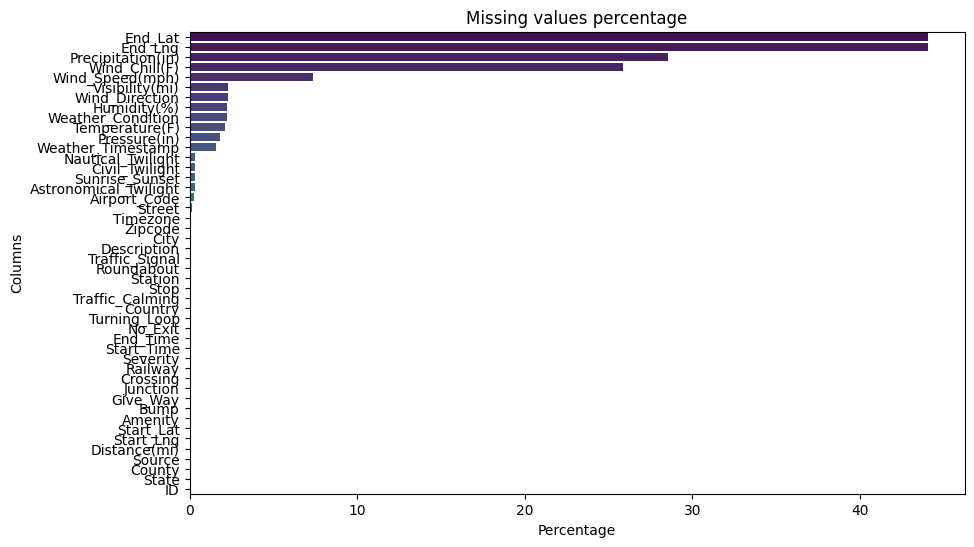

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x=percentages.values, y=percentages.index, palette="viridis")
plt.title('Missing values percentage')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.show()

We can see that there are only a few features where the problem of missing values is significant: **End_Lat** and **End_Lng** have over 40% of missing values - those columns are not vital for our analysis (we also have **Start_Lat** and **Start_Lng** columns that don't suffer from this problem), thus we can just discard them. Missing values ration for **Precipitation(in)** and **Wind_Chill(F)** around 28% and 25%, respectively. The rest of variables have less than 10% missing values, which can be easily solved by an appropriate missing values imputation, such as KNN imputation that would ensure the distributions of features would be sustained, or just by a simple mean or median for columns with small percentages of missing values.

We can divide our features into 3 general categories: location of the accident, weather and traffic conditions. We're going to inspect each of them separately.

### 1. Location

We have 9 columns related to location: 4 categorical ones (**City**, **County**, **State**, **Zipcode**) and 5 continuous (**Start_Lat**, **Start_Lng**, **End_Lat**, **End_Lng**, **Distance(mi)**).

In [6]:
location_cat = ['City', 'County', 'State', 'Zipcode']

for col in location_cat:
    print(col)
    print('Number of unique values:', df[col].nunique(), '\n')

City
Number of unique values: 13678 

County
Number of unique values: 1871 

State
Number of unique values: 49 

Zipcode
Number of unique values: 825094 



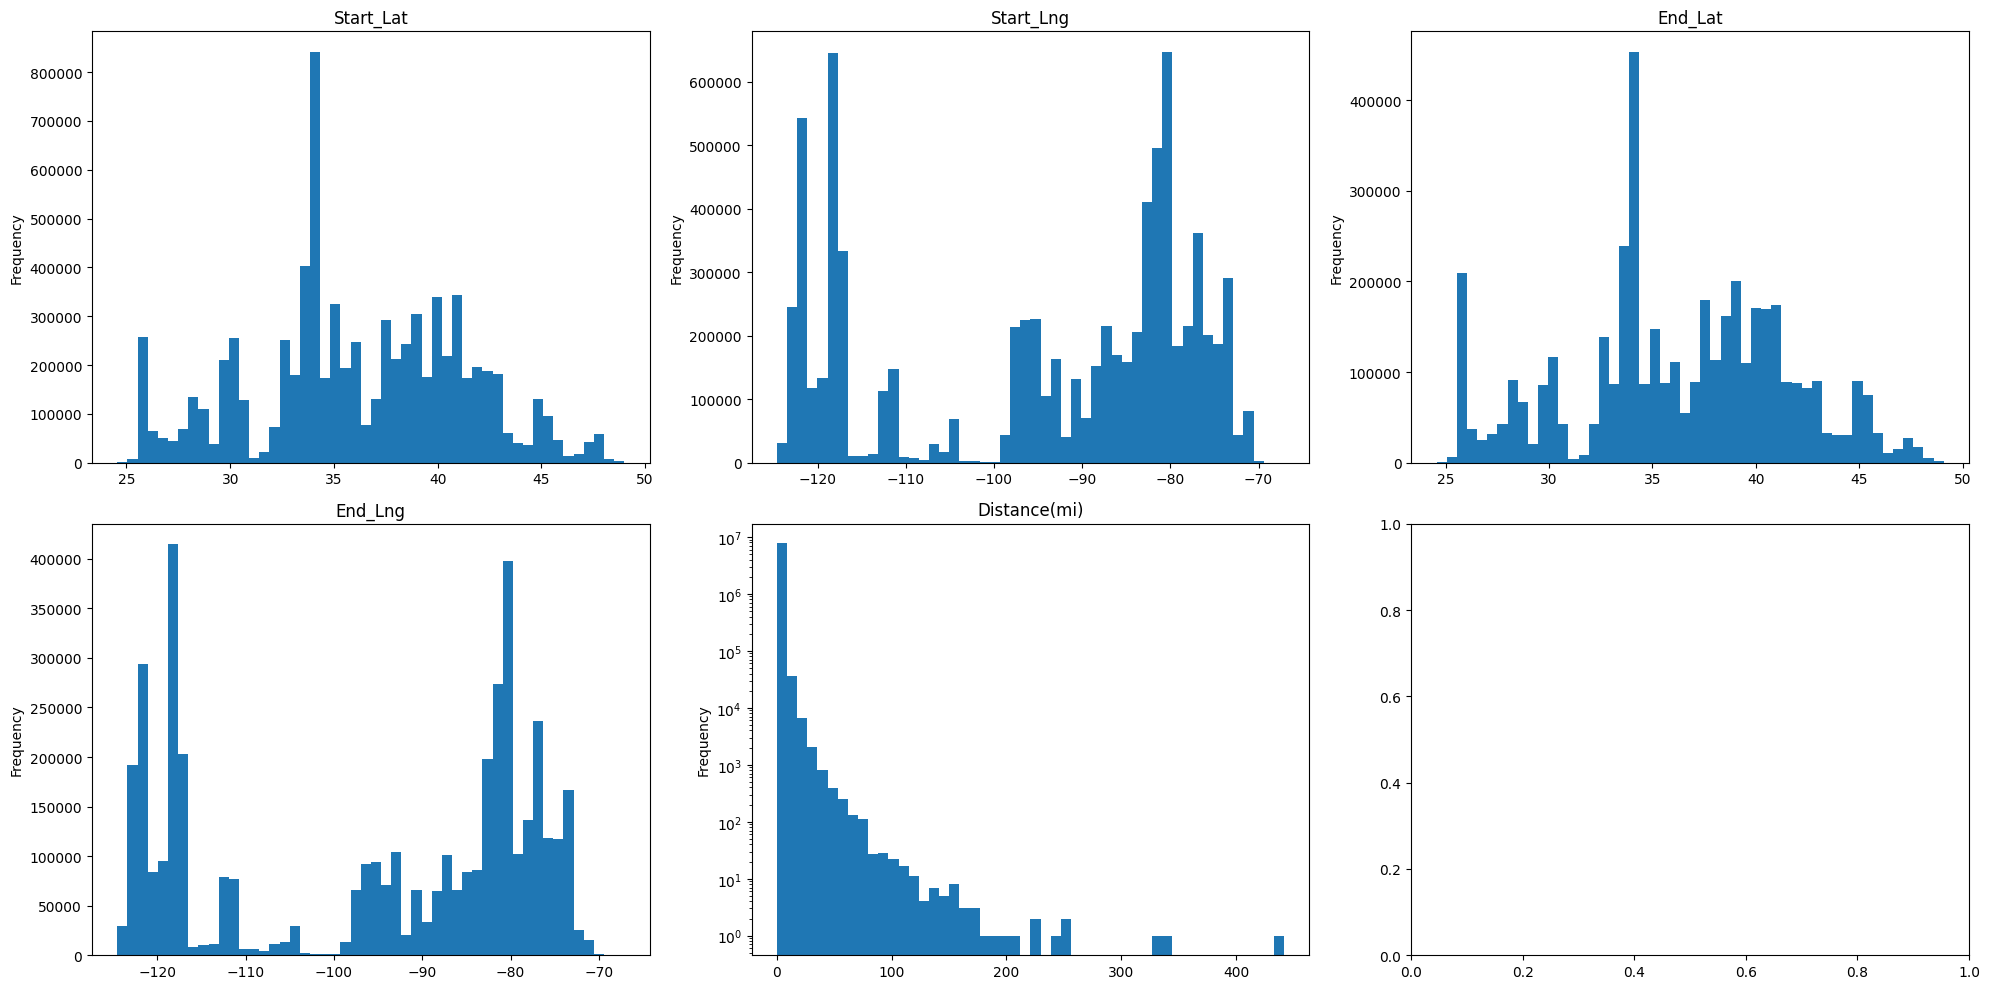

In [7]:
location_cont = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)']

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, col in enumerate(location_cont):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df[col].plot(kind='hist', ax=ax, bins=50)
    if col == 'Distance(mi)':
        ax.set_yscale('log')  # Set logarithmic scale for 'Distance(mi)' column
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()


The plot above shows histogram of each of continuous location columns. We can see that both **Start_Lng** and **End_Lng** have bimodal distributions, **Distance(mi)** seems to follow power-law distribution. Note that we aim to discard **End_Lat**, **End_Lng** and **Distance(mi)** in our analysis.

### 2. Weather

There are 9 columns that seem relevant in our analysis. 2 categorical: **Weather_Condition**, **Wind_Direction**, and 7 continuous: **Temperature(F)**, **Wind_Chill(F)**, **Humidity(%)**, **Pressure(in)**, **Visibility(mi)**, **Wind_Speed(mph)**, **Precipitation(in)**.

In [8]:
weather_cat = ['Weather_Condition', 'Wind_Direction']

for col in weather_cat:
    print(col)
    print('Number of unique values:', df[col].nunique(), '\n')

Weather_Condition
Number of unique values: 144 

Wind_Direction
Number of unique values: 24 



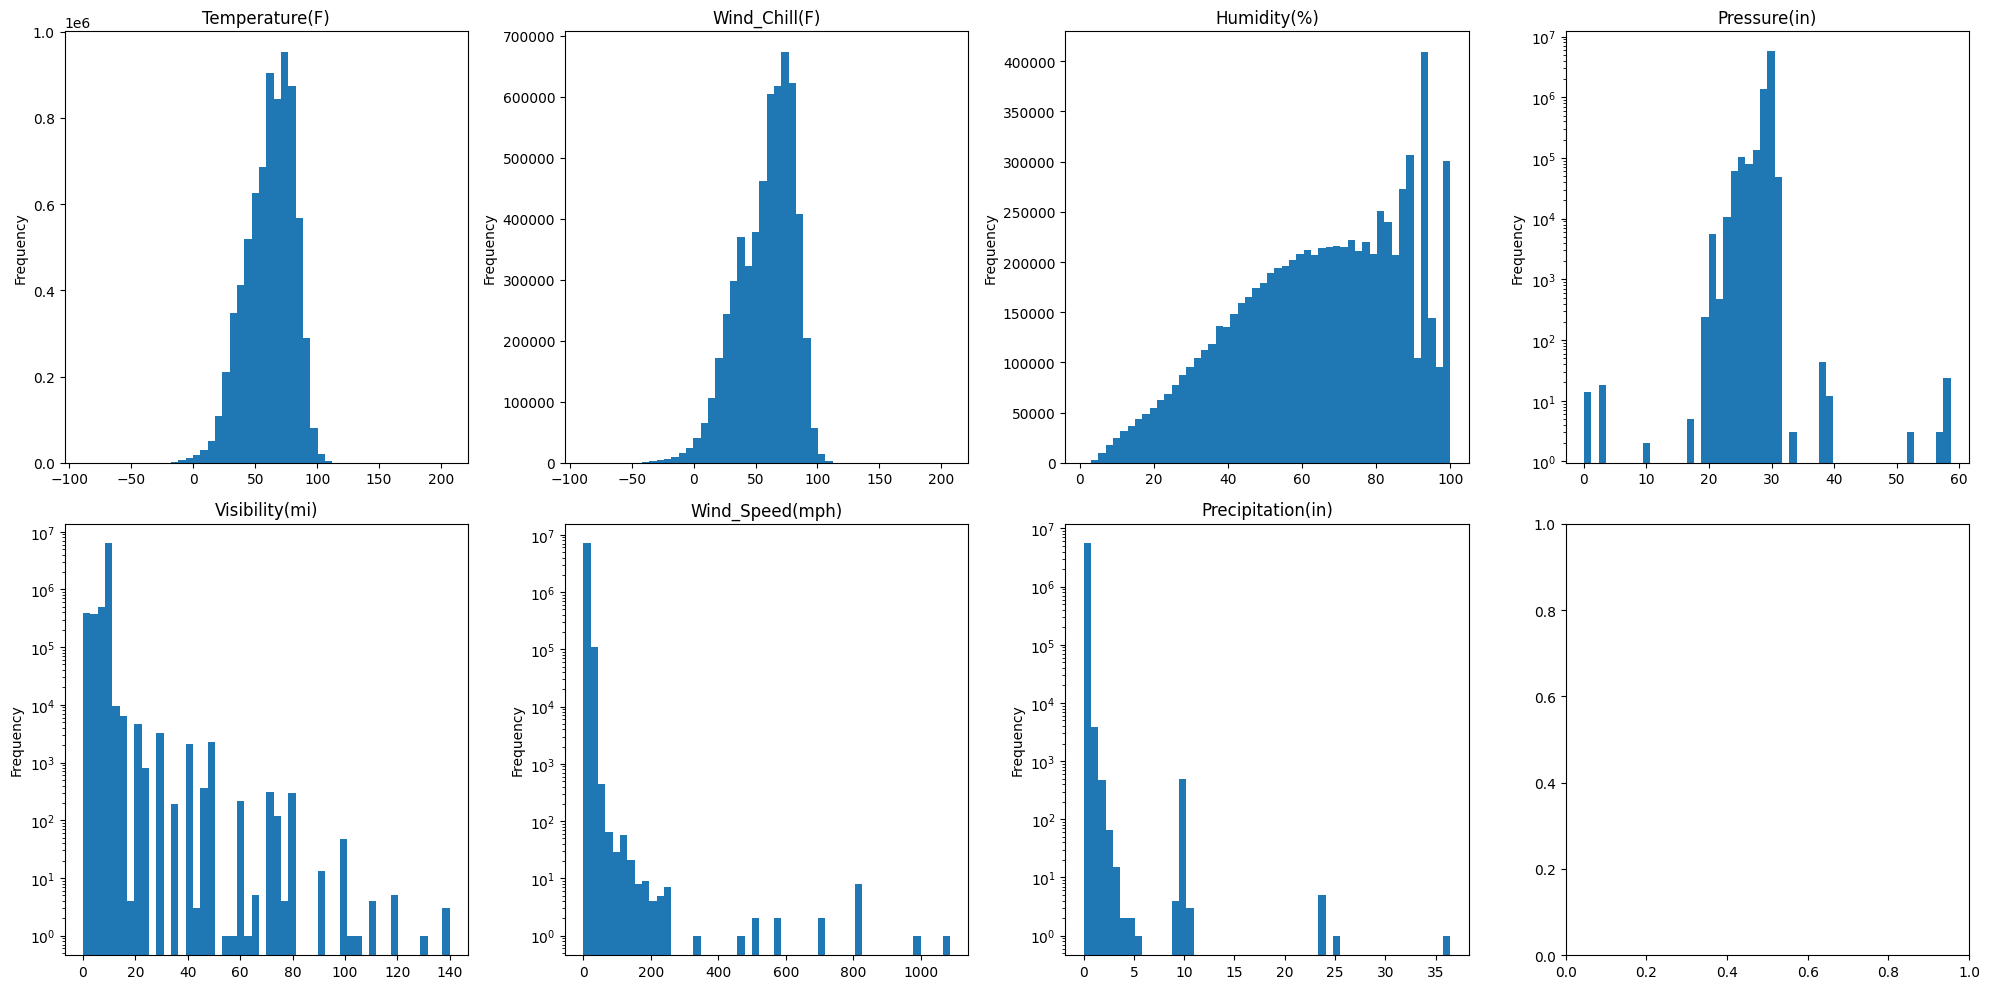

In [9]:
weather_cont = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
                'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

num_rows = 2
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, col in enumerate(weather_cont):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df[col].plot(kind='hist', ax=ax, bins=50)
    if col in ['Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']:
        ax.set_yscale('log')  # Set logarithmic scale for 'Distance(mi)' column
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()


In the plot above we can see that **Temperature(F)**, **Wind_Chill(F)** and **Pressure(in)** have approximately Gaussian distributions, and **Humidity(%)** has approximately Half-Cauchy distribution.

### 3.Traffic

For traffic category we only have 13 categorical columns that specify if there's a specific object/place in the neighbourhood of the accident, e.g. roundabout, station, or crossing.

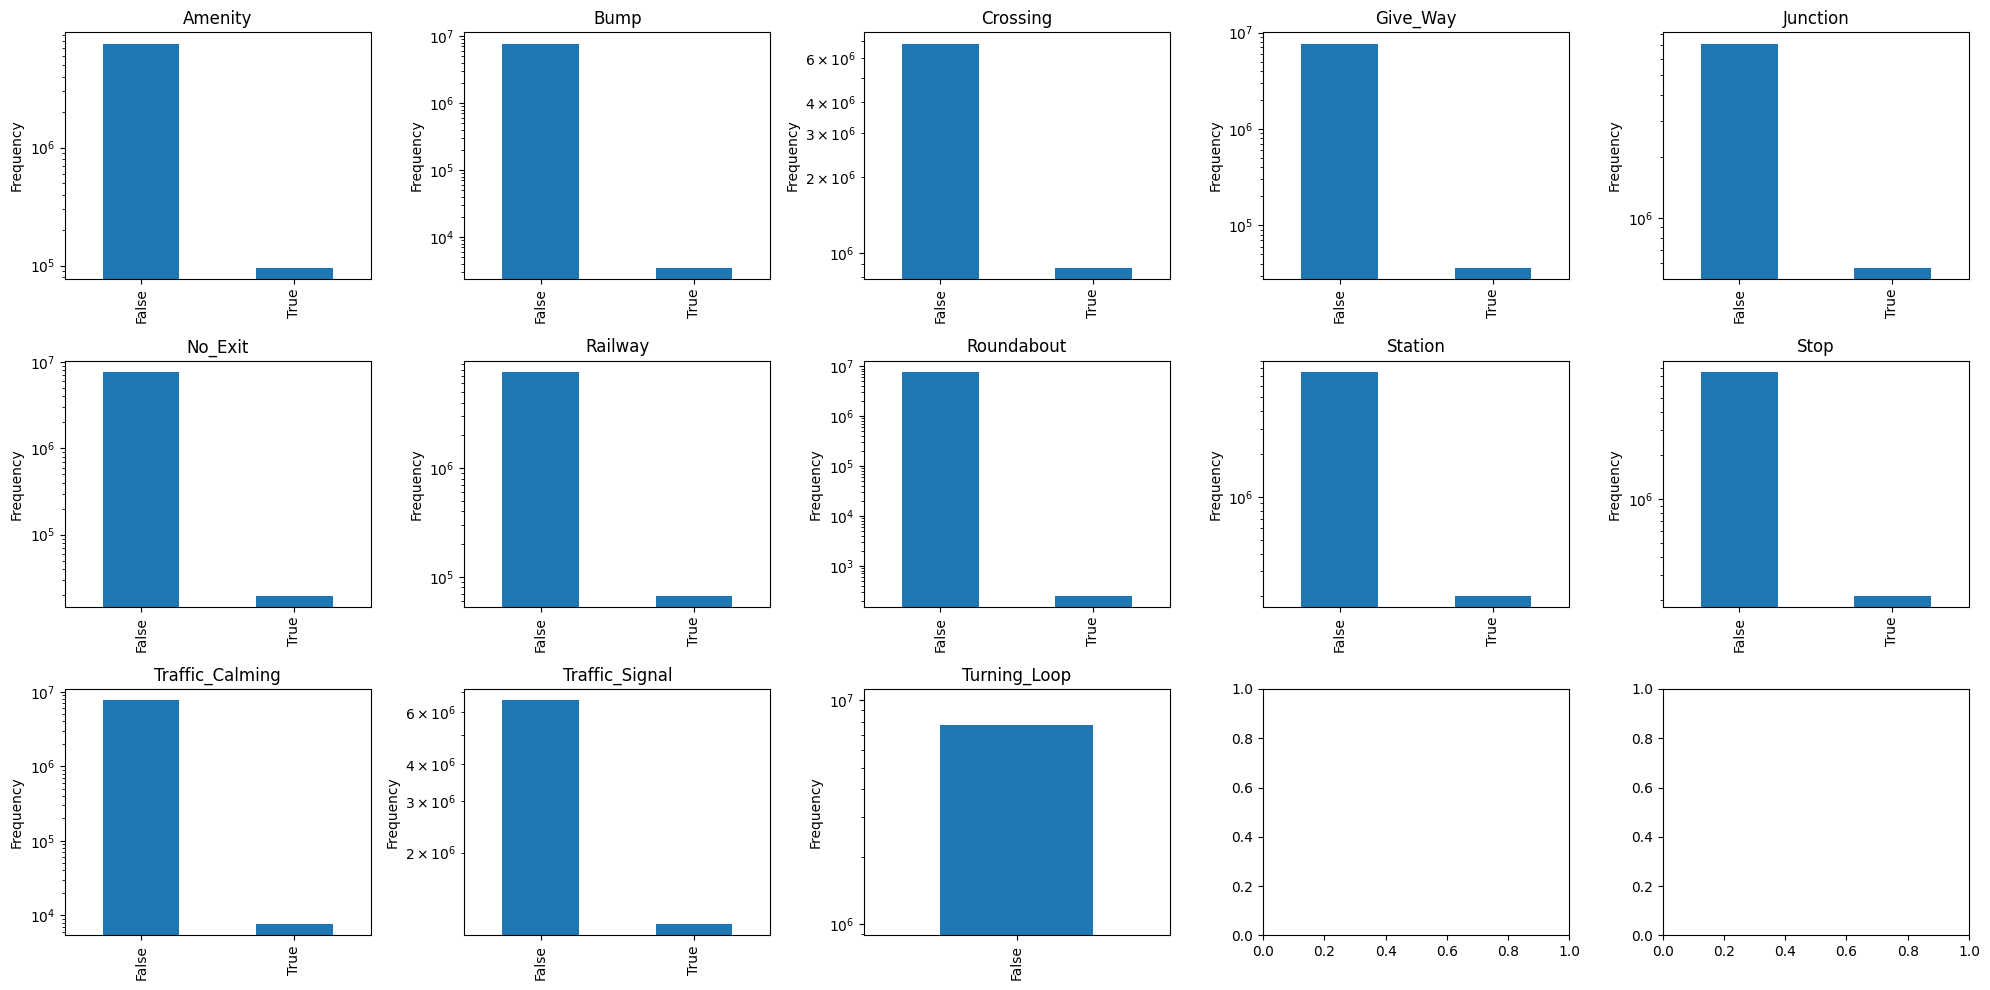

In [10]:
traffic_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way','Junction', 
                'No_Exit', 'Railway', 'Roundabout','Station', 'Stop', 
                'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, col in enumerate(traffic_cols):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout()
plt.show()

For all traffic variables, majority of records is equal to false (apart from turning loop, which didn't appear even once in the dataset, thus we can discard this column). Below we can see percentages of True and False values for each column. We can see that traffic calming and bump are most common, appearing in respectively around 15% and 11% of all records.

In [11]:
for i, col in enumerate(traffic_cols):
    print(df[col].value_counts(normalize=True))

False    0.987535
True     0.012465
Name: Amenity, dtype: float64
False    0.999545
True     0.000455
Name: Bump, dtype: float64
False    0.886941
True     0.113059
Name: Crossing, dtype: float64
False    0.995267
True     0.004733
Name: Give_Way, dtype: float64
False    0.926072
True     0.073928
Name: Junction, dtype: float64
False    0.997471
True     0.002529
Name: No_Exit, dtype: float64
False    0.991333
True     0.008667
Name: Railway, dtype: float64
False    0.999968
True     0.000032
Name: Roundabout, dtype: float64
False    0.973875
True     0.026125
Name: Station, dtype: float64
False    0.972262
True     0.027738
Name: Stop, dtype: float64
False    0.999017
True     0.000983
Name: Traffic_Calming, dtype: float64
False    0.852004
True     0.147996
Name: Traffic_Signal, dtype: float64
False    1.0
Name: Turning_Loop, dtype: float64


## First modelling choice - severity of accidents

In the first approach we wanted to model the severity of accidents across the US based on time, weather data and objects in the vicinity of accident.

In [12]:
def plot_severity(data, state=None):
    if state:
        data = data[data['State'] == state]
    plt.hist(data['Severity'], bins=[0.5, 1.5, 2.5, 3.5, 4.5], width=0.7)
    plt.yscale('log')
    plt.xlabel('Severity')
    plt.ylabel('Accident count')
    plt.title('Severity of accidents histogram')
    plt.xticks(range(1, 5))
    plt.show();

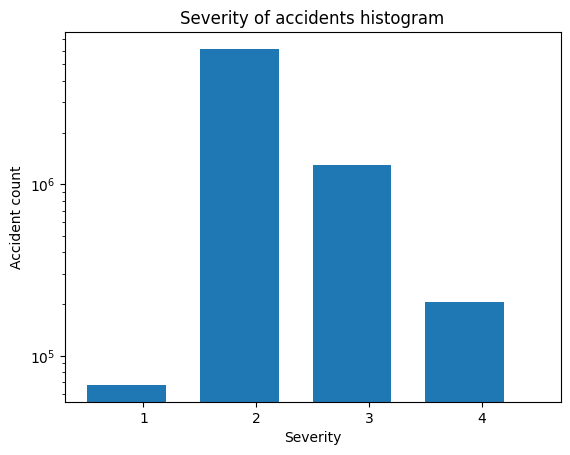

In [13]:
plot_severity(df)

In [14]:
df["Severity"].value_counts(normalize=True)

2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: Severity, dtype: float64

We can see that majority (80%) of accidents have severity equal to 2, 17% of accidents have severity equal to 3, only 2.6% have the highest possible severity and less than one 1% of the records were the least severe.

Below we can see how the situation looked like in separate states:

Text(0.5, 1.02, 'Severity of accidents for different states')

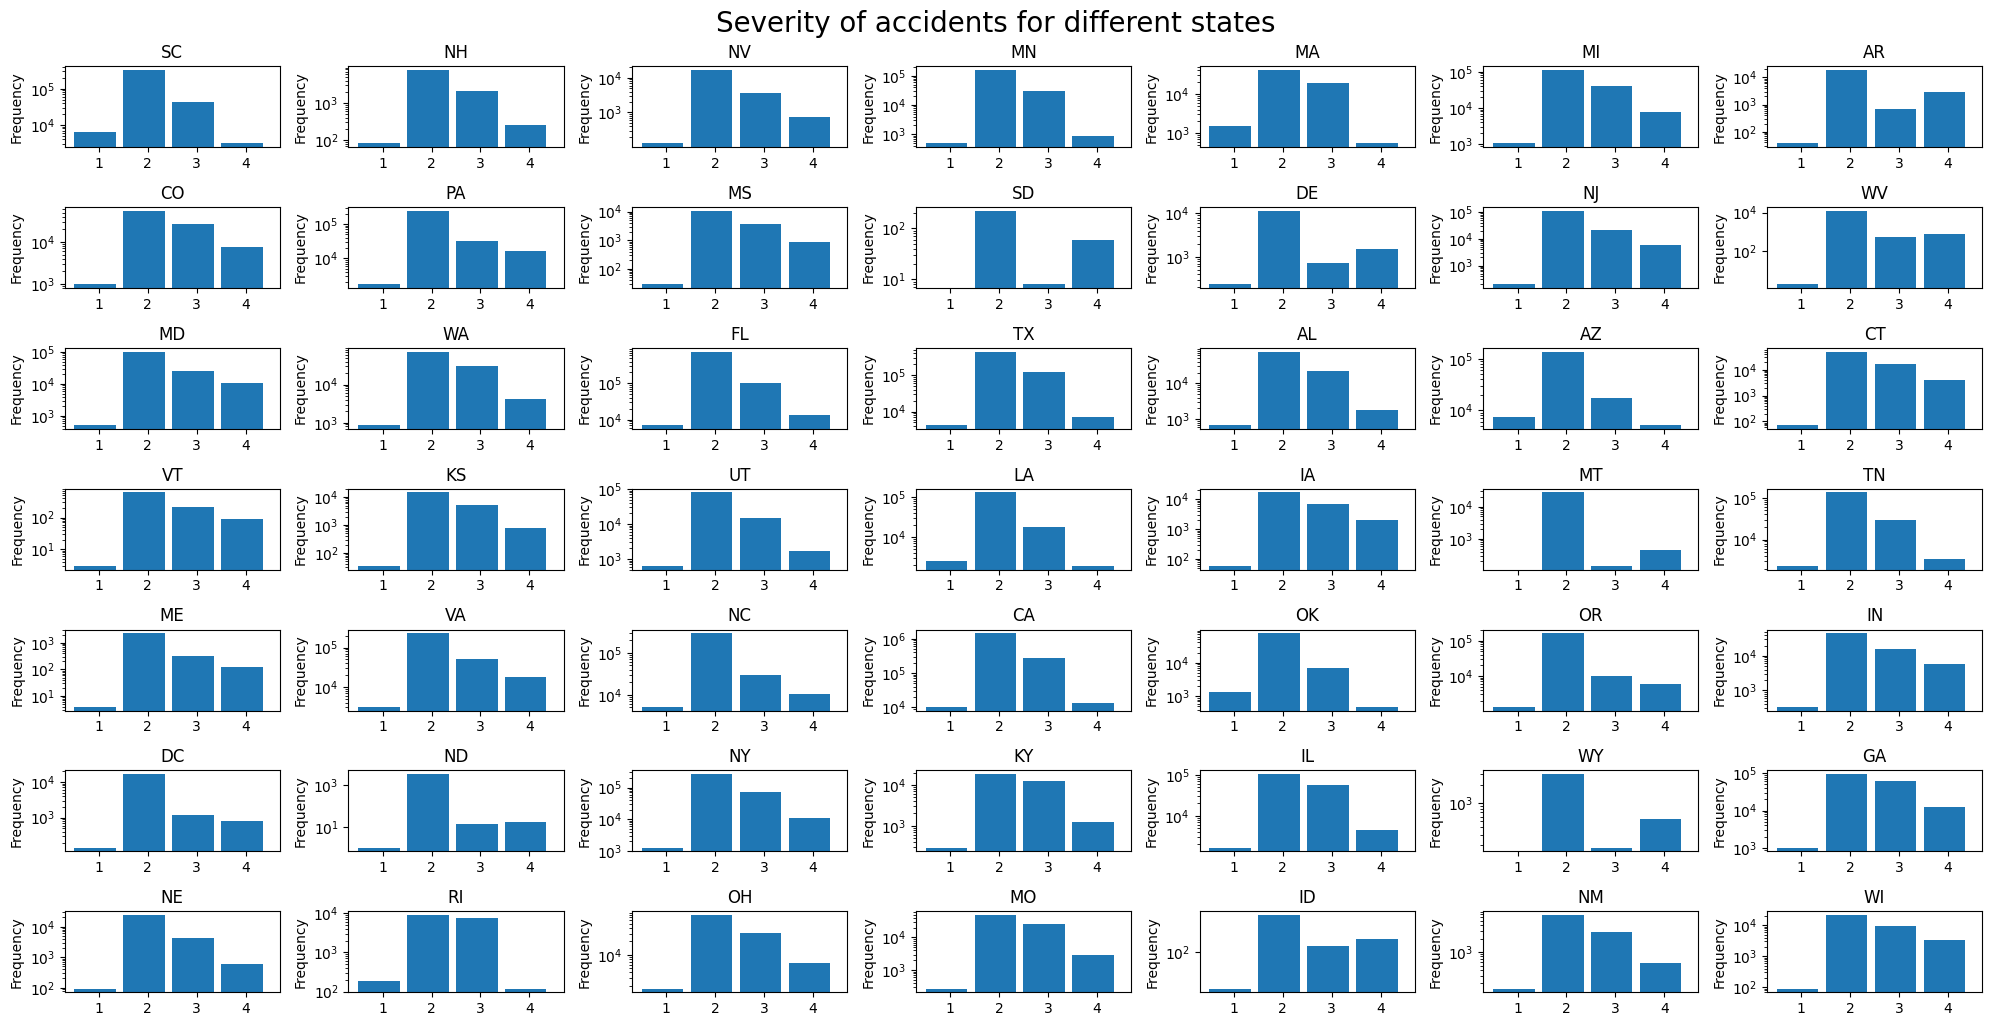

In [15]:
states = set(df['State'].values)

num_rows = 7
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust figsize as needed

for i, state in enumerate(states):
    row_index = i // num_cols  # Calculate the row index
    col_index = i % num_cols  # Calculate the column index
    ax = axes[row_index, col_index]  # Access the axis
    df[df['State'] == state]['Severity'].plot(kind='hist', ax=ax, bins=[0.5, 1.5, 2.5, 3.5, 4.5], width=0.85)
    ax.set_xticks(range(1, 5))
    ax.set_yscale('log')
    ax.set_title(state)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')    

# Adjust layout
plt.tight_layout(pad=1.)  # Increase pad value to add space between subplots
plt.suptitle('Severity of accidents for different states', y=1.02, fontsize=20)  # Adjust y value for the suptitle position


We can see that now the situation is quite different: severity equal to 2 still has the highest occurence in all of the states, but there are states like Rhode Island or Kentucky where there's almost the same percentage of accident with severity 2 and 3. There are also states, like Montana, South Dakota or West Virginia, where there are more accidents of severity 4 that severity 3. Looking at the above, it seems interesting to model the accidents' severity for each state instead of for the whole country as a total.

In [3]:
# transform data type 
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
# how many accidents in different years
df['Year'] = df['Start_Time'].dt.year  
# Drop rows where Year is 2023
df = df[df['Year'] != 2023]

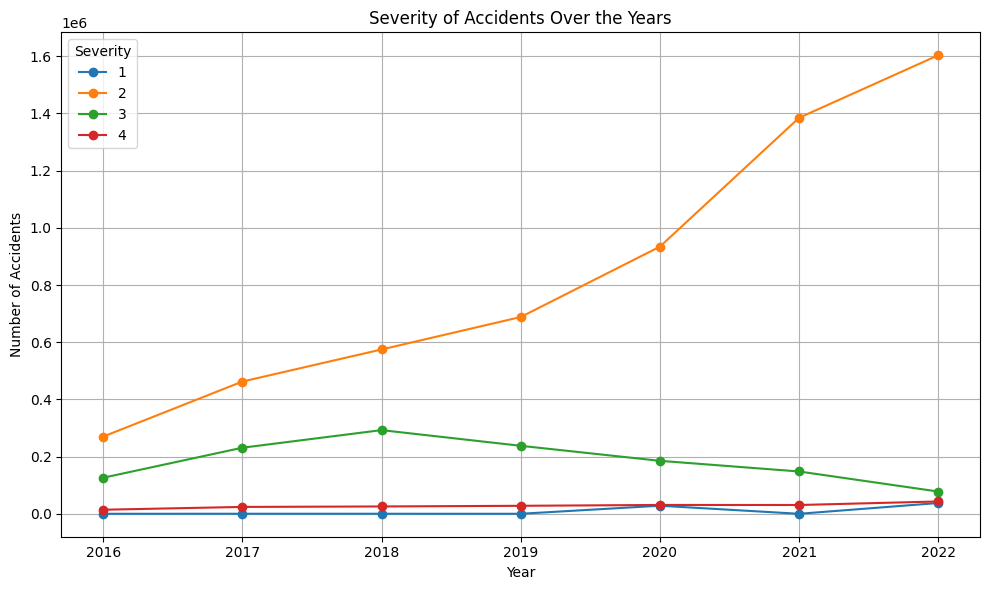

In [17]:
# Group data by year and severity, and count the number of accidents
severity_counts = df.groupby(['Year', 'Severity']).size().unstack(fill_value=0)

# Plot the severity of accidents over the years
severity_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Severity of Accidents Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

In the plot above we can see how the severity of accidents changed over the years. Number of the most and the least severe accidents was quite stable during the years. Accidents with severity 3 had a peak in 2018, but since then the number of accidents was slowly decreasing throughout the years. What's interesting is that the number of accidents with severity 2 (and a total number of accidents as well) has been sharply increasing every single year.

In [8]:
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60

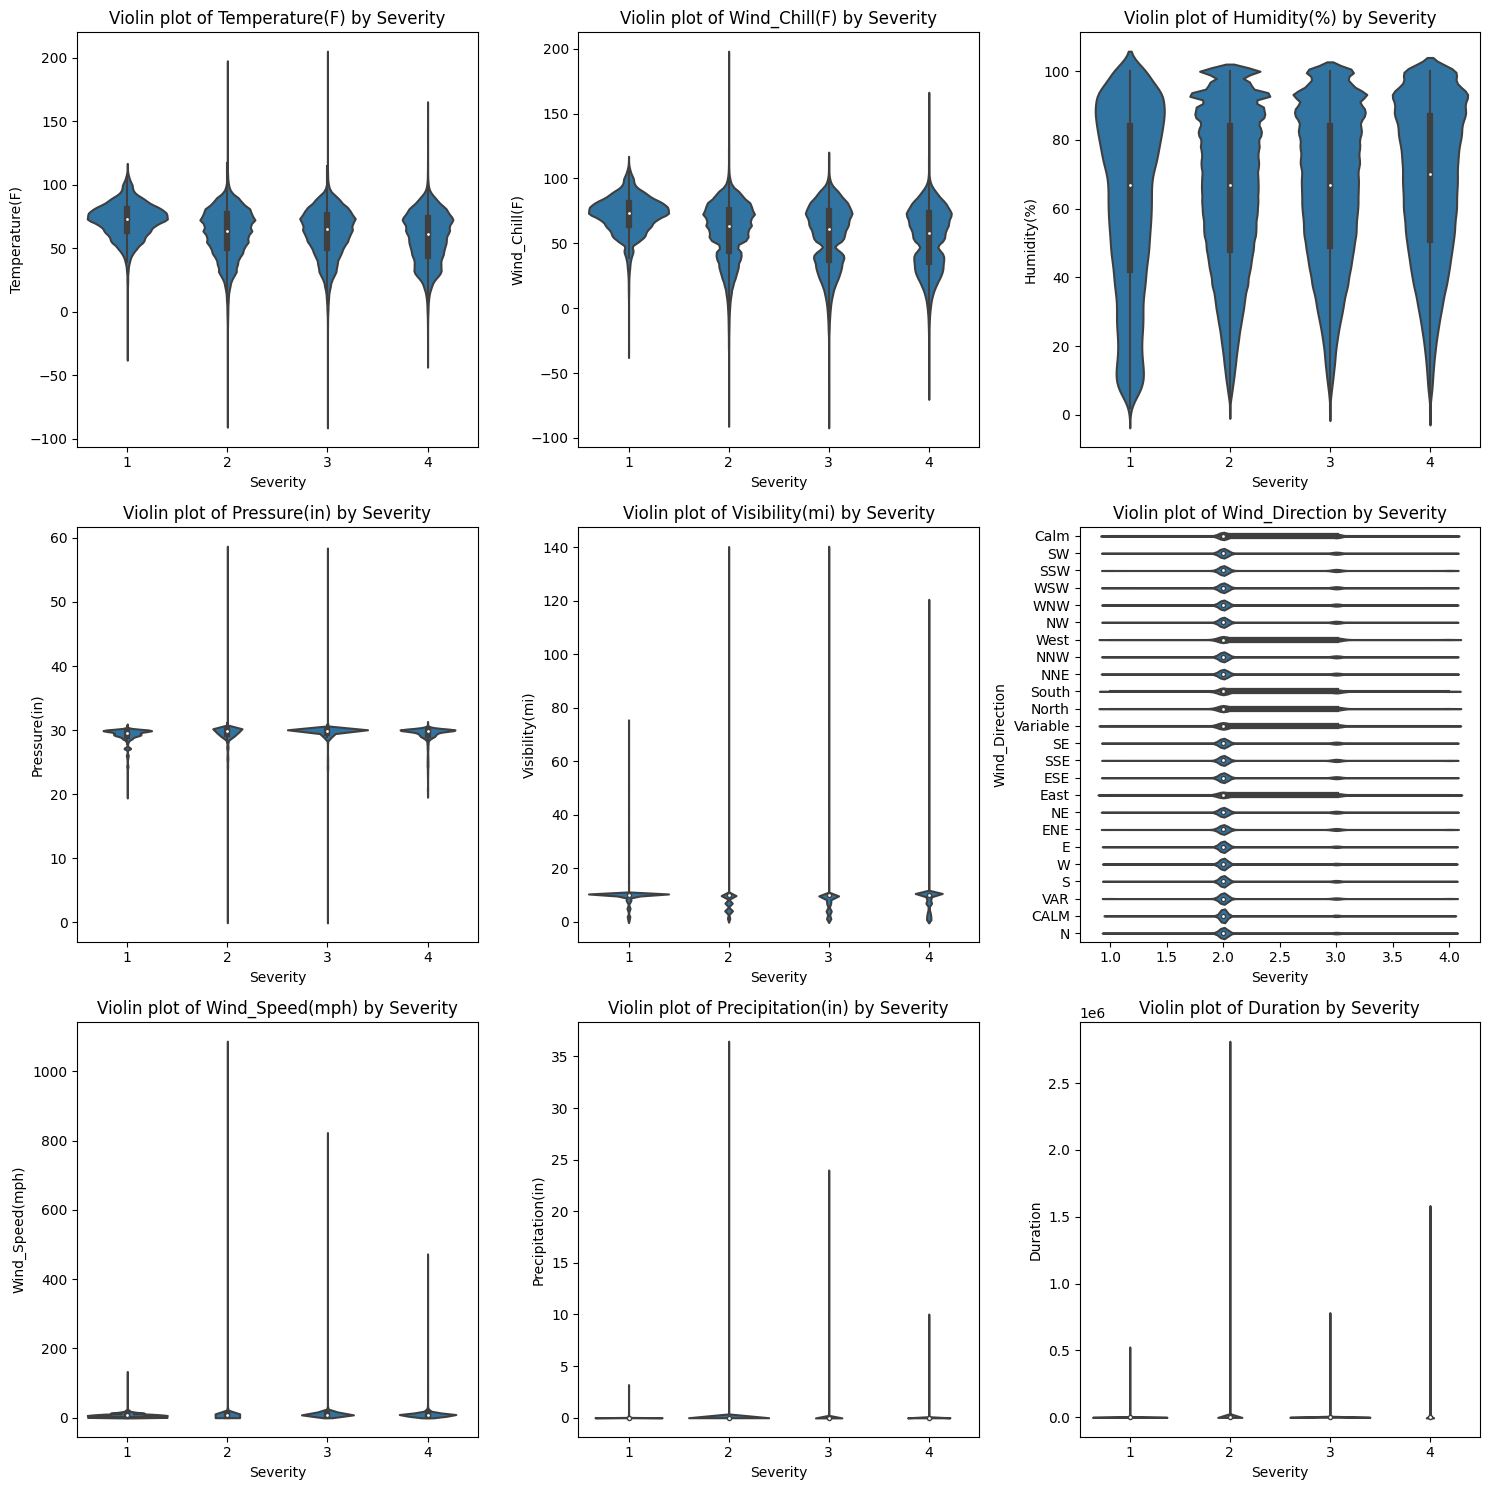

In [12]:
# Features to plot
features = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
            'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Duration']

blue_palette = sns.color_palette(["#1f77b4"])

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.violinplot(x='Severity', y=feature, data=df, ax=axes[i], palette=blue_palette)
    axes[i].set_title(f'Violin plot of {feature} by Severity')

plt.tight_layout()
plt.show()

In the plot above we can see the distribution of selected features for each severity type, shown in the form of violin plots. We decided to use this kind of visualization to compare distributions between different severities and see if they differ - that would suggest that we could model the severity of the accidents using weather or duration features. Unfortunately, we can see that the distributions look similar for all of the severity types. It suggests that it will be difficult to model this variable.

To explore this issue further, we created correlation matrix between different features. We decided to look into correlation between duration and distance and other features, since, according to discussion on Kaggle, the severity feature is created mostly based on duration of road disruptions and distance of those disruptions. That's why we figured that if we'll find correlation between those and the weather, we'll be able to model the severity as well.

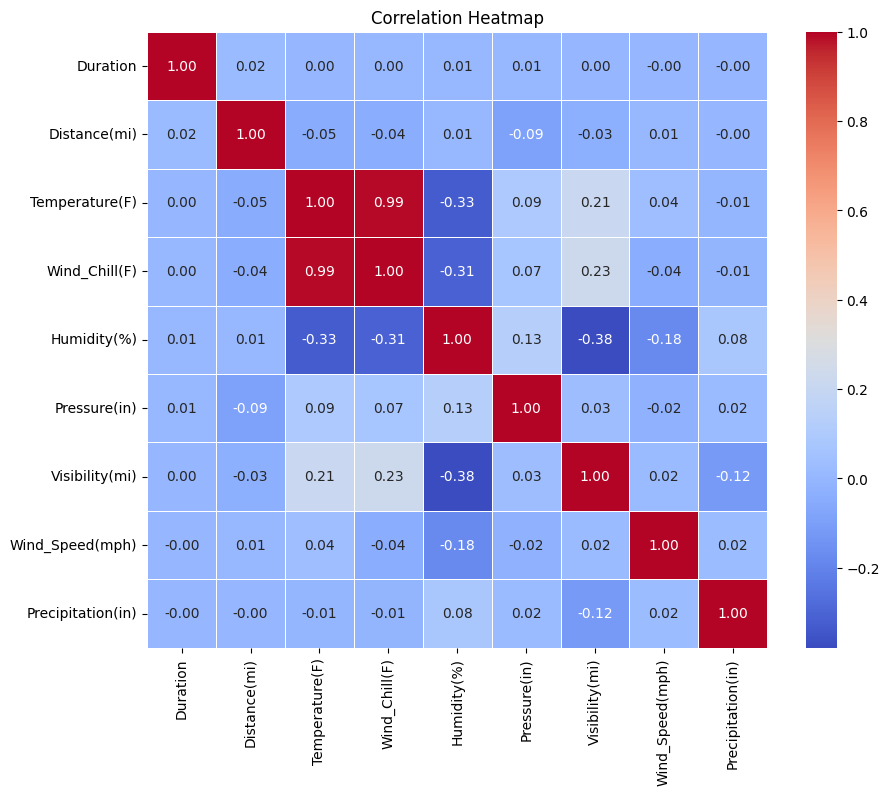

In [10]:
features = ['Duration', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
            'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']


correlation_matrix = df[features].corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

As we can see, there are almost no correlations between either duration or distance and weather features. That's why later we decided to change our modelling choice and focus on number of accidents instead of the severity.

As the last step of severity investigation, we also looked at the location of accidents of different severities and see if maybe this will help us in predicting how severe the accidents would be.

In [2]:
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
us_states = gpd.read_file(url)

In [3]:
df = pd.read_csv("US_Accidents_March23.csv")

In [5]:
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

In [6]:
# Define the plot parameters for each severity
severities = {
    1: {'color': '#5cff4a', 'marker': 'o', 'size': 5, 'label': 'Severity 1'},
    2: {'color': '#ffb340', 'marker': '+', 'size': 5, 'label': 'Severity 2'},
    3: {'color': '#ff1c1c', 'marker': 'x', 'size': 5, 'label': 'Severity 3'},
    4: {'color': '#6459ff', 'marker': 'v', 'size': 5, 'label': 'Severity 4'}
}

# Plot configuration function
def plot_severity(ax, severity):
    params = severities[severity]
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])
    us_states.boundary.plot(ax=ax, color='black')

    geo_df[geo_df['Severity'] == severity].plot(
        ax=ax,
        markersize=params['size'],
        color=params['color'],
        marker=params['marker'],
        label=params['label']
    )

    for i in ['bottom', 'top', 'left', 'right']:
        side = ax.spines[i]
        side.set_visible(False)

    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labelleft=False, labelbottom=False)

    ax.set_title(f'Severity {severity}', size=20, color='grey')
#     ax.legend(prop={'size': 15}, loc='lower right', borderpad=1,
#               labelcolor=params['color'], edgecolor='white')


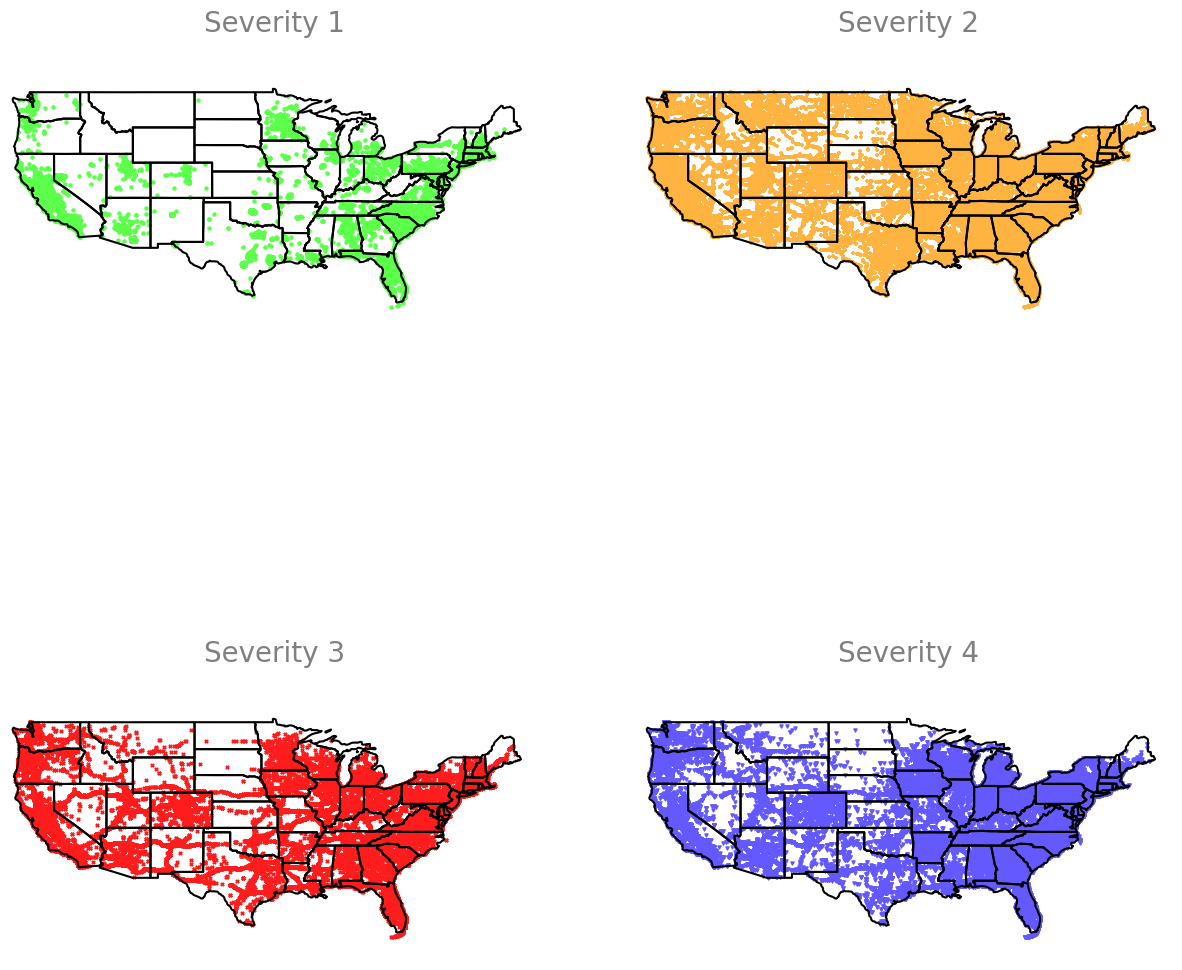

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot_severity(ax[0, 0], 1)
plot_severity(ax[0, 1], 2)
plot_severity(ax[1, 0], 3)
plot_severity(ax[1, 1], 4)
plt.show()

In the plots above we can see location of accidents of different severities. Accidents of severities 1, 3 and 4 have lower occurrence densities in the centre and north of the US (or they don't happen there at all), whereas accidents of severity 2 can be observed everywhere. Based on these maps we can see that there's not a clear distinction of accidents' severities based on the location and severities of all types tend to happen in the same locations.

Taking all of the above into account, severity seemd to be infeasible modelling choice. The lack of correlation between it and weather features, e.g. temperature or precipitation, as well as location of the accidents, made us consider a different modelling choice. We decided to foucs on the number of accidents instead of severity.

# Number of accidents

We decided to shift our focus into modelling number of accidents. Below we analyse the distribution of number of accidents throughout different time periods and, places with the biggest number of accidents and the distribution of accidents in different weather conditions.

In [11]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,NaT,NaT,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,NaT,NaT,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,NaT,NaT,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,NaT,NaT,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,NaT,NaT,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


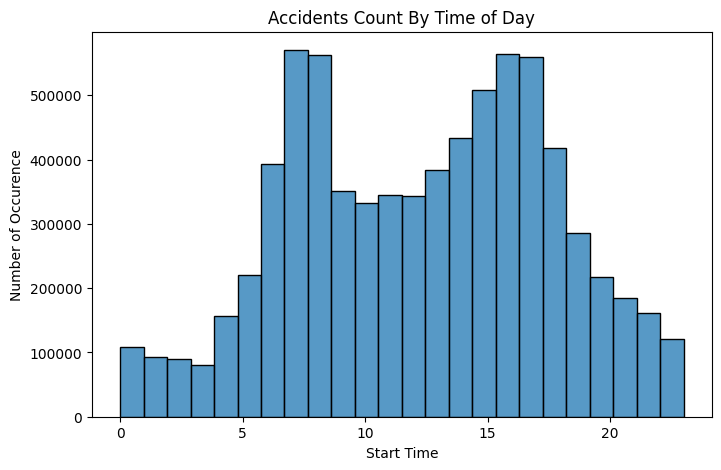

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(df['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Start Time")
plt.ylabel("Number of Occurence")
plt.title('Accidents Count By Time of Day')

plt.show()

In the ploat above we can see the distribution of number of accidents over the hours of the day. As one could expect, we can observe two peaks: around 9 a.m. and 5 p.m. These are peak hours - people are usually travelling to/from work then, so the probability of an accident in these hours is definitely higher. There is much smaller number of accidents during the night - which is also understandable because there's much less traffic during the night.

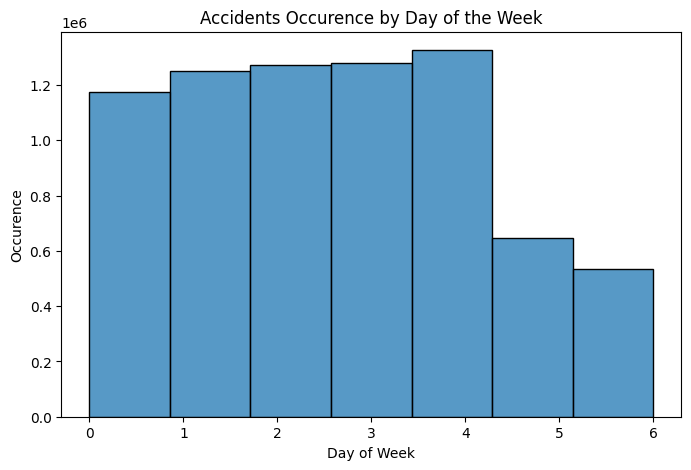

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(df['Start_Time'].dt.dayofweek, bins = 7)

plt.xlabel("Day of Week")
plt.ylabel("Occurence")
plt.title('Accidents Occurence by Day of the Week')

plt.show()

We can also see how does the distribution of number of accidents looks like during the week - and this one is also quite intuitive. Most accidents happen during weekdays, with the largest number of accidents on Friday. There's much less accidents on weekends with the smallest number on Sunday. 

In [6]:
saturday = df[df['Start_Time'].dt.dayofweek == 5]
sunday = df[df['Start_Time'].dt.dayofweek == 6]

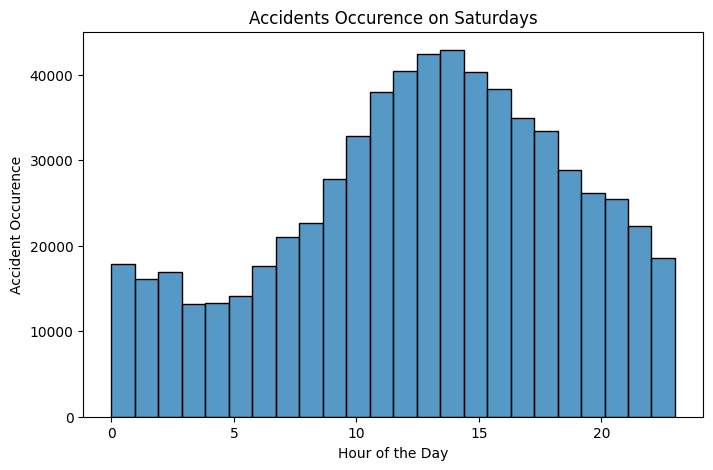

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(saturday['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Hour of the Day")
plt.ylabel("Accident Occurence")
plt.title('Accidents Occurence on Saturdays')

plt.show()

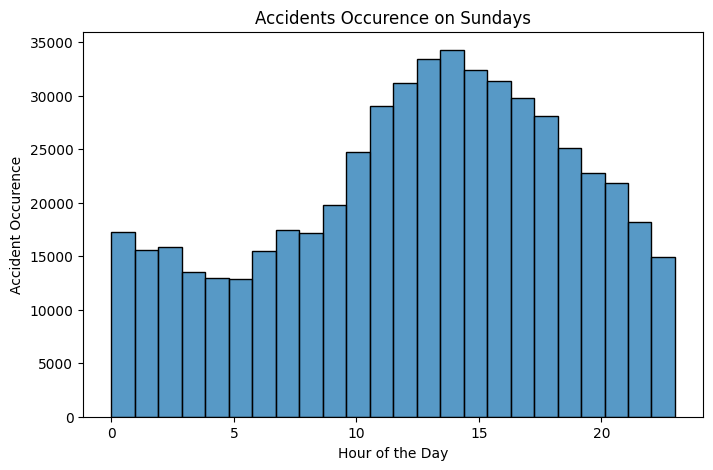

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(sunday['Start_Time'].dt.hour, bins = 24)

plt.xlabel("Hour of the Day")
plt.ylabel("Accident Occurence")
plt.title('Accidents Occurence on Sundays')

plt.show()

We saw before the distribution of number of accidents over the hours. We also decided to inspect how it looks like specifically for Saturdays and Sundays. We can see that the situation is quite different - most accidents happen in the middle of the day, around 15, and the least accidents happen around 5 in the morning.

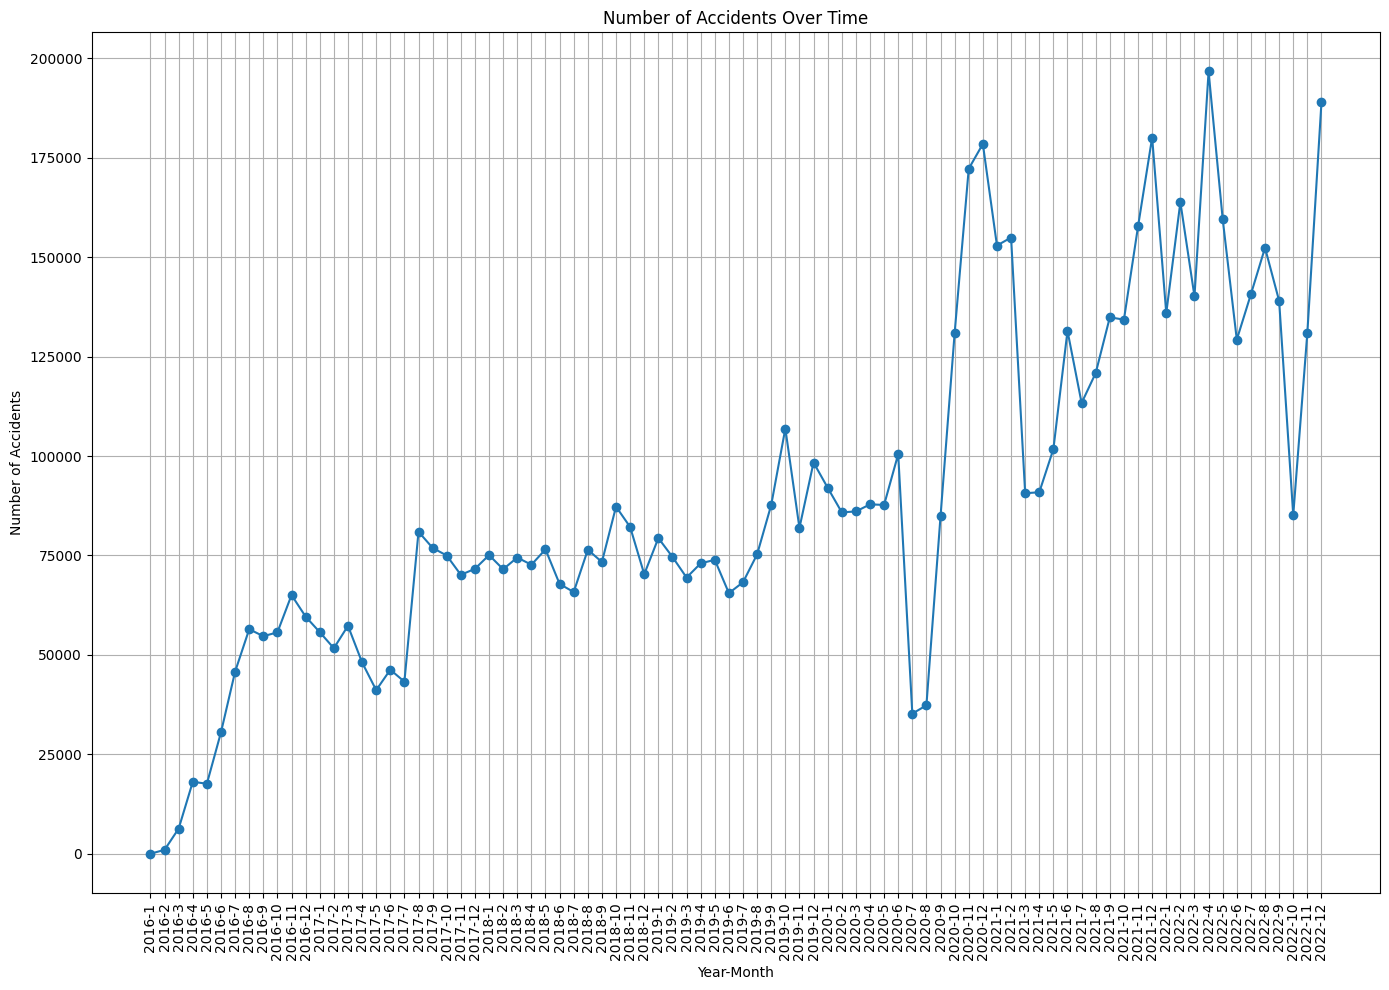

In [9]:
# Extract year and month from 'Start_Time'
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month

# Group by year and month, and count the number of accidents
accidents_per_month = df.groupby(['Year', 'Month']).size().reset_index(name='Accident_Count')

# Plotting
plt.figure(figsize=(14, 10))
plt.plot(accidents_per_month['Year'].astype(str) + '-' + accidents_per_month['Month'].astype(str), accidents_per_month['Accident_Count'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over Time')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


Above we can see how the number of accidents changed over the months. There's a general positive trend, but we can also see some interesting patterns. Most years we can see some drops around summer time, and there's one huge drop in July and August 2020. It's probably caused not only by holiday, but also the fact that there was a global pandemic and people were travelling much less. There's also a huge peak right after summer 2020. We can see that we have almost no accidents at the beginning of 2016, which might cause some doubts about quality of the data and poses a question if we should use a whole dataset in our analysis.

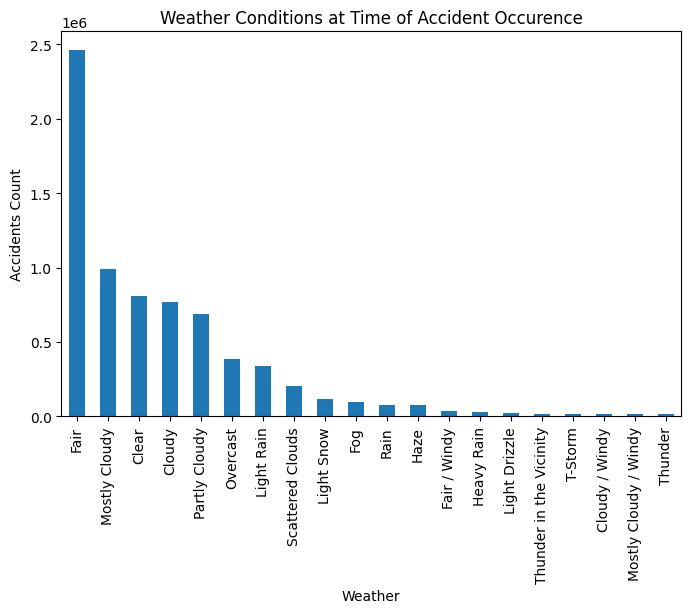

In [24]:
weather_conditions = df.groupby(['Weather_Condition']).count()['ID']

fig, ax = plt.subplots(figsize=(8,5))
weather_conditions.sort_values(ascending=False)[:20].plot(kind='bar')
ax.set(title = 'Weather Conditions at Time of Accident Occurence',
       xlabel = 'Weather',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we can see the distribution of accidents during specific weather conditions. It's interesting that, contrary to what one may suspect, most accidents happend during fair weather conditions, and much less of them happen during e.g. rain or snow. At the same time we have to remember that when the conditions are difficult less people might decide to drive a car, so the number of accidents is indeed smaller - but the severity might be higher.

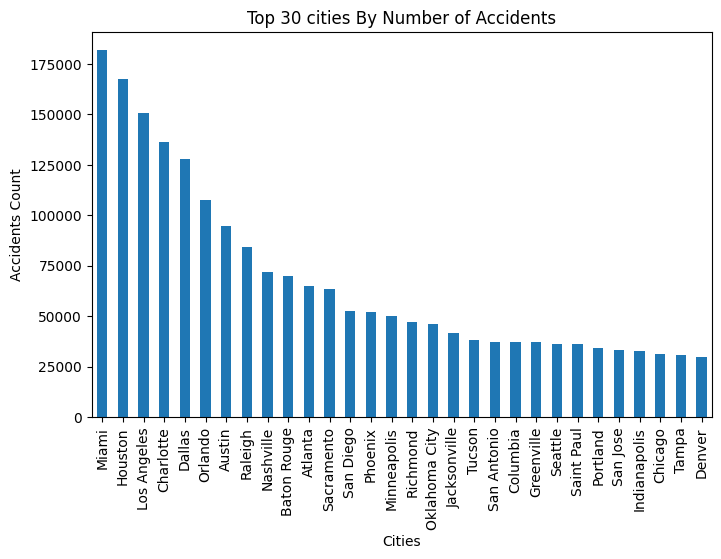

In [10]:
accidents_by_cities = df['City'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
accidents_by_cities[:30].plot(kind='bar')
ax.set(title = 'Top 30 cities By Number of Accidents',
       xlabel = 'Cities',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we cann see 30 cities that have the higher number of accidents. Although we shouldn't make any definite conclusions about this distribution without comparing it to the cities' areas or population, we can still see that there are some cities that are much more problematic than others: e.g. Miami has the highest number of accidents, and it's only a 44th city in USA when it comes to population according to 2022 statistics - which is something to look into.

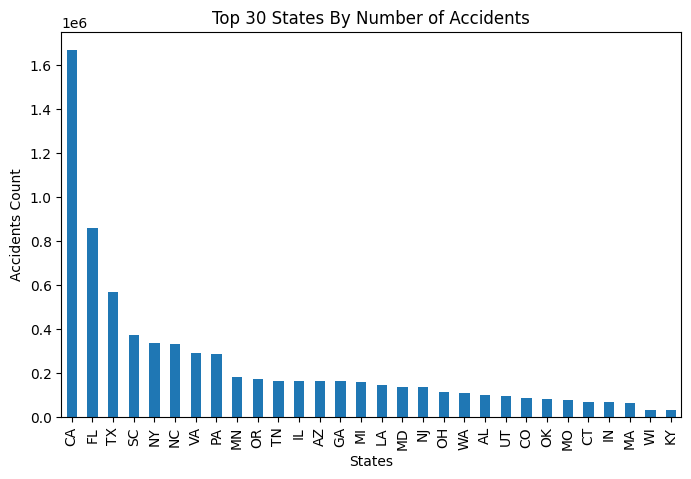

In [11]:
accidents_by_State = df['State'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
accidents_by_State[:30].plot(kind='bar')
ax.set(title = 'Top 30 States By Number of Accidents',
       xlabel = 'States',
       ylabel = 'Accidents Count')
plt.show()

In the plot above we can see the distribution of accidents in different states. There is a highest number of accidents in California, which is the most populous state and the 3rd largest in the US, but there are 2 times more accidents than in Florida (which is the 3rd most populous state, but only 22nd when it comes to area)!

# REORIENTING THE STUDY AND DATA PROCESSING

After exploratory data analysis, we decided to shift our focus into modelling number of accidents instead of severity of accidents. Since the dataset we're working with is huge (7728394 records), and our computational possibilities are limited, we decided to focus only on California data, which has the higher number of accidents out of all states, for 2022.

Our idea is to model number of accidents per hour if different areas of California. A natural way to divide California into areas is to use geohashes. We decided to create geohashes of precision 4 and 5: smaller ones would very often have zero accidents, and larger ones wouldn't capture dependences specific to some areas.

### CREATING GEOHASHES 4 AND 5

Below we filter the dataset only for California, year 2022 and add geohashes of precision 4 and 5.

In [43]:
df = pd.read_csv("US_Accidents_March23.csv")

In [51]:
df = df[df['State'] == 'CA'].reset_index(drop=True)

In [52]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"])
df["year"] = df["Start_Time"].dt.year

In [53]:
df = df[df['year'] == 2022].reset_index(drop=True)

In [54]:
def get_geohash(lat, lon, precision):
    return pygeohash.encode(lat, lon, precision=precision)

In [55]:
df['geohash4'] = df.apply(lambda row: get_geohash(row['Start_Lat'], row['Start_Lng'], 4), axis=1)
df['geohash5'] = df.apply(lambda row: get_geohash(row['Start_Lat'], row['Start_Lng'], 5), axis=1)

In [56]:
print("We have {} unique geohashes of precision 5 and {} unique geohashes of precision 4.".format(df["geohash5"].nunique(), df["geohash4"].nunique()))

We have 7243 unique geohashes of precision 5 and 565 unique geohashes of precision 4.


In [57]:
df.to_csv("CA_geohash.csv", index=False)

## ADDITIONAL DATASOURCE - WEATHER DATA

Since we want to model number of accidents per hour, we'll also have to deal with the fact that there are hours when no accidents occurred in certain geohashes. That also means that we won't have weather data for those records. But, of course, we want to be able to model the situations when no accidents happen, and we'd like to use weather data as one of the features types. In order to solve this problem, we found an external dataset, which contains historical data from all of the weather stations in California from [*National Centers for Environmental Information*](https://www.ncei.noaa.gov/access/search/data-search/global-hourly?bbox=42.002,-124.393,32.536,-114.125&place=State%20or%20Province:48&pageNum=1&startDate=2016-01-01T00:00:00&endDate=2023-01-01T23:59:59).

In order to get the same data as we did, one has to filter dates from 2022-01-01 to 2022-12-31, set location as California and click *Select All* button. Then, after submitting a request, all of the data are sent to one's email as a csv file.

## MERGING WEATHER DATA WITH TRAFFIC DATA

### 1. ASSIGNING EACH GEOHASH A CLOSEST WEATHER STATION

The weather dataset contains information about locations of weather stations. The most obvious idea would be to find the weather conditions closest to the time and location of each of the traffic accident. Due to the size of our dataset, this approach is not possible, since it would require us to calculate a distance between each accident location and weather station. Instead, we decided to assign a weather station to each of the geohashes. For every geohash, we calculated distance between it and every weather station, and we assigned to it a closest weather station.

We found the closest stations both for geohashes 4 and 5 and saved them in separate csv files.

In [2]:
df_ca = pd.read_csv("CA_geohash.csv")

In [2]:
df_weather = pd.read_csv("3700709.csv.gz")
df_weather.head()

C:\Users\malgo\AppData\Local\Temp\ipykernel_16404\3405659967.py:1: DtypeWarning: Columns (0,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,128,129,130,131,133,135,136,138) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv("3700709.csv.gz")


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,AA2,AA3,AB1,AD1,AE1,AH1,AH2,AH3,AH4,AH5,AH6,AI1,AI2,AI3,AI4,AI5,AI6,AJ1,AK1,AL1,AM1,AN1,AO1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AU1,AU2,AU3,AW1,AW2,AW3,AW4,AX1,AX2,AX3,AX4,CALL_SIGN.1,CB1,CF1,CF2,CF3,CG1,CG2,CG3,CH1,CI1,CIG,CN1,CN2,CN3,CO1,CR1,CT1,CT2,CT3,CU1,CU2,CU3,CV1,CV2,CV3,CW1,DEW,ED1,EQD,GA1,GA2,GA3,GA4,GD1,GD2,GD3,GD4,GE1,GF1,GH1,IB2,KA1,KA2,KA3,KA4,KB1,KB2,KB3,KC1,KC2,KD1,KD2,KE1,KF1,KG1,KG2,MA1,MD1,MF1,MG1,MH1,MK1,MV1,MW1,MW2,MW3,MW4,OB1,OC1,OD1,OE1,OE2,OE3,QUALITY_CONTROL.1,REM,REPORT_TYPE.1,RH1,RH2,RH3,SA1,SLP,SOURCE.1,TMP,UA1,UG1,VIS,WA1,WND
0,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T07:55:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,C",NaN,R01 M047TMP046R02 M087DPT046,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10098,5,07864,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07512/31/21 23:55:02 METAR KL35 010755Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0040,C",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0036,5"
1,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:15:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,5",NaN,NaN,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10095,5,07861,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0077,5",NaN,NaN,NaN,NaN,V020,MET07801/01/22 00:15:02 METAR KL35 010815Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0040,5",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0046,5"
2,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:35:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,5",NaN,NaN,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10098,5,07864,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07501/01/22 00:35:02 METAR KL35 010835Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0050,5",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0046,5"
3,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:55:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,C",NaN,R01 M057TMP046R02 M087DPT046,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10102,5,07867,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07501/01/22 00:55:02 METAR KL35 010855Z 250...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0050,C",NaN,NaN,"016093,5,N,5",NaN,"250,5,N,0026,5"
4,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T09:15:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
df_stations = df_weather[["STATION", "NAME", "LATITUDE", "LONGITUDE"]].drop_duplicates().reset_index(drop=True)

df_stations["STATION"] = df_stations["STATION"].astype(str)
df_stations = df_stations.drop_duplicates().reset_index(drop=True)
df_stations.rename(columns={"STATION": "station_id", "NAME": "name", "LATITUDE": "station_latitude", "LONGITUDE": "station_longitude"}, inplace=True)

df_stations.head()

,station_id,name,station_latitude,station_longitude
0,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.26400,-116.85400
1,72288023152,"BURBANK GLENDALE PASADENA AIRPORT, CA US",34.19966,-118.36543
2,72289793206,"SAN LUIS OBISPO MCCHESNEY FIELD, CA US",35.23815,-120.64406
3,72495723213,"SANTA ROSA SONOMA CO AIRPORT, CA US",38.50369,-122.81101
4,72289903179,"CHINO AIRPORT, CA US",33.97563,-117.62487


In [5]:
df_stations.to_csv("stations.csv",index=False)

In [6]:
df_geo = df_ca[['geohash5']].drop_duplicates().reset_index(drop=True)
df_geo.head()

,geohash5
0,9qhh7
1,9q56q
2,9qcee
3,9qh0t
4,9qh0f


In [8]:
df_geo["coords"] = df_geo["geohash5"].apply(lambda x: pgh.decode(geohash=x))

df_geo["lat"] = df_geo["coords"].apply(lambda x: x[0])
df_geo["lon"] = df_geo["coords"].apply(lambda x: x[1])

In [9]:
df_geo.to_csv("geo5_coords.csv", index=False)

In [13]:
geohash_coords = df_geo[['lat', 'lon']].values
weather_station_coords = df_stations[['station_latitude', 'station_longitude']].values

# Compute distance matrix
distances = cdist(geohash_coords, weather_station_coords, metric='euclidean')

# Find the index of the closest weather station for each geohash
closest_stations_idx = np.argmin(distances, axis=1)

# Map the indices to station_ids
df_geo['closest_station'] = df_stations.loc[closest_stations_idx, 'station_id'].values

In [14]:
df_geo.head()

,geohash5,coords,lat,lon,closest_station
0,9qhh7,"(34.5, -118.0)",34.5,-118.0,72382023182
1,9q56q,"(34.2, -118.9)",34.2,-118.9,72392623136
2,9qcee,"(38.6, -121.5)",38.6,-121.5,99999923271
3,9qh0t,"(33.9, -117.9)",33.9,-117.9,72297603166
4,9qh0f,"(33.9, -118.0)",33.9,-118.0,72297603166


In [17]:
df_geo.to_csv("geohash5_mapping.csv", index=False)

In [18]:
df_geo4 = df_ca[['geohash4']].drop_duplicates().reset_index(drop=True)
df_geo4.head()

,geohash4
0,9qhh
1,9q56
2,9qce
3,9qh0
4,9qdk


In [19]:
df_geo4["coords"] = df_geo4["geohash4"].apply(lambda x: pgh.decode(geohash=x))
df_geo4["lat"] = df_geo4["coords"].apply(lambda x: x[0])
df_geo4["lon"] = df_geo4["coords"].apply(lambda x: x[1])

In [20]:
df_geo4.to_csv("geo4_coords.csv", index=False)

In [21]:
geohash4_coords = df_geo4[['lat', 'lon']].values
weather_station_coords = df_stations[['station_latitude', 'station_longitude']].values

# Compute distance matrix
distances = cdist(geohash4_coords, weather_station_coords, metric='euclidean')

# Find the index of the closest weather station for each geohash
closest_stations_idx = np.argmin(distances, axis=1)

# Map the indices to station_ids
df_geo4['closest_station'] = df_stations.loc[closest_stations_idx, 'station_id'].values

In [22]:
df_geo4.head()

,geohash4,coords,lat,lon,closest_station
0,9qhh,"(35.0, -118.0)",35.0,-118.0,72317153144
1,9q56,"(34.0, -119.0)",34.0,-119.0,72391093111
2,9qce,"(39.0, -121.0)",39.0,-121.0,72026723224
3,9qh0,"(34.0, -118.0)",34.0,-118.0,74704303165
4,9qdk,"(37.0, -120.0)",37.0,-120.0,74504693242


In [23]:
df_geo4.to_csv("geohash4_mapping.csv", index=False)

### 2. CALCULATING NUMBER OF ACCIDENTS PER HOUR PER GEOHASH

Since our goal is to model number of accidents per hour in geohashes, we first need to create a dataset of this kind.

In [27]:
df = pd.read_csv("CA_geohash.csv")
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)

In [28]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [29]:
# Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

In [31]:
merged_df.rename(columns={"hour": "date"}, inplace=True)

In [33]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['date'].dt.hour
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek  # Monday=0, Sunday=6

In [34]:
# Extract month and day of the month
merged_df["month"] = merged_df["date"].dt.month
merged_df["day"] = merged_df["date"].dt.day

In [35]:
merged_df.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day
0,2022-01-01,9qhh7,0.0,0,5,1,1
1,2022-01-01,9q56q,1.0,0,5,1,1
2,2022-01-01,9qcee,0.0,0,5,1,1
3,2022-01-01,9qh0t,0.0,0,5,1,1
4,2022-01-01,9qh0f,0.0,0,5,1,1


In [36]:
merged_df.to_csv("accident_counts.csv", index=False)

### 3. MERGING COUNT DATA PER HOUR PER GEOHASH WITH WEATHER STATION ID

Now that we have a dataset with our count data, we want to add a weather station location for each record. We'll use closest station ids found above in order to achieve that.

In [40]:
df_geo = pd.read_csv("geohash5_mapping.csv")
df_geo.rename(columns={"lat": "geohash_latitude", "lon": "geohash_lon", "closest_station": "station_id"}, inplace=True)

In [41]:
accidents_with_station_df = pd.merge(merged_df, df_geo, on='geohash5', how='left')

In [45]:
accidents_with_station_df.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day,coords,geohash_latitude,geohash_lon,station_id
0,2022-01-01,9qhh7,0.0,0,5,1,1,"(34.5, -118.0)",34.5,-118.0,72382023182
1,2022-01-01,9q56q,1.0,0,5,1,1,"(34.2, -118.9)",34.2,-118.9,72392623136
2,2022-01-01,9qcee,0.0,0,5,1,1,"(38.6, -121.5)",38.6,-121.5,99999923271
3,2022-01-01,9qh0t,0.0,0,5,1,1,"(33.9, -117.9)",33.9,-117.9,72297603166
4,2022-01-01,9qh0f,0.0,0,5,1,1,"(33.9, -118.0)",33.9,-118.0,72297603166


In [44]:
accidents_with_station_df.to_csv("accident_with_station_counts.csv", index=False)

### 4. MERGING COUNT DATA WITH WEATHER DATA

Now that we have a weather station assigned to every record, we can finally merge it with our weather data. Unfortunately, when we were trying to achieve that, we were getting the `MemoryError`. That's why we decided to analyse only one geohash at a time. For starter, we focused on the geohash with the largest number of accidents in total.

In [2]:
df_weather = pd.read_csv("3700709.csv.gz")
df_weather.head()

C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\3405659967.py:1: DtypeWarning: Columns (0,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,128,129,130,131,133,135,136,138) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv("3700709.csv.gz")


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,AA1,AA2,AA3,AB1,AD1,AE1,AH1,AH2,AH3,AH4,AH5,AH6,AI1,AI2,AI3,AI4,AI5,AI6,AJ1,AK1,AL1,AM1,AN1,AO1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AU1,AU2,AU3,AW1,AW2,AW3,AW4,AX1,AX2,AX3,AX4,CALL_SIGN.1,CB1,CF1,CF2,CF3,CG1,CG2,CG3,CH1,CI1,CIG,CN1,CN2,CN3,CO1,CR1,CT1,CT2,CT3,CU1,CU2,CU3,CV1,CV2,CV3,CW1,DEW,ED1,EQD,GA1,GA2,GA3,GA4,GD1,GD2,GD3,GD4,GE1,GF1,GH1,IB2,KA1,KA2,KA3,KA4,KB1,KB2,KB3,KC1,KC2,KD1,KD2,KE1,KF1,KG1,KG2,MA1,MD1,MF1,MG1,MH1,MK1,MV1,MW1,MW2,MW3,MW4,OB1,OC1,OD1,OE1,OE2,OE3,QUALITY_CONTROL.1,REM,REPORT_TYPE.1,RH1,RH2,RH3,SA1,SLP,SOURCE.1,TMP,UA1,UG1,VIS,WA1,WND
0,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T07:55:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,C",NaN,R01 M047TMP046R02 M087DPT046,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10098,5,07864,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07512/31/21 23:55:02 METAR KL35 010755Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0040,C",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0036,5"
1,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:15:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,5",NaN,NaN,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10095,5,07861,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0077,5",NaN,NaN,NaN,NaN,V020,MET07801/01/22 00:15:02 METAR KL35 010815Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0040,5",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0046,5"
2,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:35:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,5",NaN,NaN,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10098,5,07864,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07501/01/22 00:35:02 METAR KL35 010835Z 270...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0050,5",NaN,NaN,"016093,5,N,5",NaN,"270,5,N,0046,5"
3,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T08:55:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KL35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22000,5,9,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-0080,C",NaN,R01 M057TMP046R02 M087DPT046,"00,5,+99999,9,99,9",NaN,NaN,NaN,"0,99,1,+99999,9,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10102,5,07867,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V020,MET07501/01/22 00:55:02 METAR KL35 010855Z 250...,FM-15,NaN,NaN,NaN,NaN,"99999,9",6,"-0050,C",NaN,NaN,"016093,5,N,5",NaN,"250,5,N,0026,5"
4,A0685400115,"BIG BEAR CITY AIRPORT, CA US",34.264,-116.854,2057.1,2022-01-01T09:15:00,6,FM-15,KL35,V020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
accidents_with_station_df = pd.read_csv("accident_with_station_counts.csv")

In [10]:
accidents_with_station_df.groupby(["geohash5"])["accident_count"].sum().sort_values(ascending=False)

geohash5
9q5cw    3414.0
9q5ct    3073.0
9q5cs    2697.0
9q5ch    2279.0
9q5cv    1886.0
9qh1k    1877.0
9q5c8    1842.0
9qcet    1699.0
9qh13    1683.0
9q5f2    1676.0
9qh93    1674.0
9q5bs    1605.0
9q5ck    1595.0
9q5cj    1594.0
9qh10    1594.0
9q5by    1582.0
9qh1d    1560.0
9q5c4    1535.0
9q9nm    1458.0
9q8yy    1446.0
9mudn    1424.0
9qh0j    1414.0
9qce7    1409.0
9q5cx    1375.0
9q9p1    1317.0
9mupt    1289.0
9q5cr    1263.0
9qh1m    1254.0
9mudq    1208.0
9qh3v    1199.0
9q5cm    1195.0
9q5fb    1190.0
9q5bw    1188.0
9qh1f    1162.0
9qh9f    1120.0
9q5ce    1099.0
9qh08    1072.0
9qh1q    1039.0
9q5bu    1037.0
9qh0b    1007.0
9qh0n     997.0
9mudp     997.0
9q9nk     975.0
9mudr     972.0
9q9nj     971.0
9qcem     964.0
9qceh     963.0
9mupy     961.0
9qh0v     960.0
9mu9z     949.0
9qh9d     938.0
9q5bq     935.0
9mudm     904.0
9q5c3     904.0
9q9p8     895.0
9q5c6     894.0
9qcey     875.0
9qh39     861.0
9qh45     858.0
9q5c9     839.0
9q5f7     839.0
9q5fr     839.0

In [11]:
columns_to_keep = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP']
df_weather = df_weather[columns_to_keep]

In [12]:
df_weather.rename(columns={"STATION": "station_id", "DATE": "weather_date", "LATITUDE": "station_latitude", 
                           "LONGITUDE": "station_longitude", "ELEVATION": "station_elevation", "NAME": "station_name"}, inplace=True)

C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\1652562006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather.rename(columns={"STATION": "station_id", "DATE": "weather_date", "LATITUDE": "station_latitude",


In [13]:
df_weather.to_csv("weather_filtered.csv")

In [14]:
df_weather['weather_date'] = pd.to_datetime(df_weather['weather_date'])
df_weather['hour_of_day'] = df_weather['weather_date'].dt.hour
df_weather["month"] = df_weather["weather_date"].dt.month
df_weather["day"] = df_weather["weather_date"].dt.day

C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\725108362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['weather_date'] = pd.to_datetime(df_weather['weather_date'])
C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\725108362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['hour_of_day'] = df_weather['weather_date'].dt.hour
C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\725108362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [15]:
df_weather["hour_of_day"] = df_weather["hour_of_day"].astype(int)
df_weather["month"] = df_weather["month"].astype(int)
df_weather["day"] = df_weather["day"].astype(int)
df_weather["station_id"] = df_weather["station_id"].astype(str)

C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\3555206513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather["hour_of_day"] = df_weather["hour_of_day"].astype(int)
C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\3555206513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather["month"] = df_weather["month"].astype(int)
C:\Users\malgo\AppData\Local\Temp\ipykernel_12912\3555206513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [16]:
accidents_with_station_df["hour_of_day"] = accidents_with_station_df["hour_of_day"].astype(int)
accidents_with_station_df["month"] = accidents_with_station_df["month"].astype(int)
accidents_with_station_df["day"] = accidents_with_station_df["day"].astype(int)
accidents_with_station_df["station_id"] = accidents_with_station_df["station_id"].astype(str)

In [2]:
geohash_code = '9q5cw'

In [17]:
one_hash_df = accidents_with_station_df[accidents_with_station_df['geohash5'] == 'geohash_code']

In [18]:
one_hash_df_weather = df_weather[df_weather['station_id'] == one_hash_df["station_id"].iloc[0]]

In [19]:
len(one_hash_df), len(one_hash_df_weather)

(8760, 10830)

In [20]:
final_df = pd.merge(
    one_hash_df,
    one_hash_df_weather,
    left_on=['month', 'day', 'hour_of_day'],
    right_on=['month', 'day', 'hour_of_day'],
    how='left'
)

In [21]:
final_df.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day,coords,geohash_latitude,geohash_lon,station_id_x,station_id_y,weather_date,station_latitude,station_longitude,station_elevation,station_name,WND,CIG,VIS,TMP,DEW,SLP
0,2022-01-01 00:00:00,9q5cw,0.0,0,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,72287493134,2022-01-01 00:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0128,5","+0089,5","10059,5"
1,2022-01-01 01:00:00,9q5cw,0.0,1,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,72287493134,2022-01-01 01:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0111,5","+0083,5","10060,5"
2,2022-01-01 02:00:00,9q5cw,0.0,2,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,72287493134,2022-01-01 02:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00914,5,M,N","016093,5,N,5","+0117,5","+0089,5","10071,5"
3,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,72287493134,2022-01-01 03:41:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00853,5,M,N","016093,5,N,5","+0122,5","+0067,5","99999,9"
4,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,72287493134,2022-01-01 03:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00945,5,M,N","016093,5,N,5","+0122,5","+0067,5","10075,5"


In [22]:
final_df.to_csv(f"full_{geohash_code}.csv", index=False)

And this way we finally have a dataset for our one, chosen geohash 5, merged with the weather data. But this isn't the end of our processing. The columns from weather dataset look quite mysterious and we need to decifer them.

**Note: we're showing the processing for only one largest geohash here. The same can be done for any of the geohashes in California with adjusting the goehash_code variable. For the sake of simplicity of this notebook we don't repeat the code for the processing for all of the geohashes we chose to analyse.**

We decided to preprocess and analyse 15 geohashes with the largest number of accidents. While processing the data, we found that some of the data from weather stations assigned to geohashes are incomplete, e.g. have records every few hours (instead every hour) or miss entire features (e.g. some weather stations didn't record visibility). That's why we chose only those geohashes where the weather data are of a high quality, i.e. geohashes:

`9mudn, 9q5bs, 9q5by, 9q5c4, 9q5ch, 9q5cj, 9q5ck, 9q5cs, 9q5ct, 9q5cv, 9q5cw, 9q5f2, 9q9nm, 9qh10, 9qh93`

The future work could include gathering weather data from different sources as well in order to fill the gaps, or assign weather stations to geohashes that actually have the hourly records for all the features we need. Even better solution would be to assign weather station for each accident separately (just because the weather station is closest to the geohash centre coordinates, it doesn't mean it's the one that's closest to the accident location), but due to the computational limitations we weren't able to do that.

### 5. DECODING WEATHER COLUMNS

Now that we have a full dataset for a geohash, we need to decifer the weather columns. In order to do that we're using [documentation](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf) provided by NCEI.



In [4]:
geohash_code = "9q5cw"
final_df = pd.read_csv(f"full_{geohash_code}.csv")

#### DECODING WIND

WIND-OBSERVATION type code

    The code that denotes the character of the WIND-OBSERVATION.
    DOM: A specific domain comprised of the characters in the ASCII character set.
    A = Abridged Beaufort
    B = Beaufort
    C = Calm
    H = 5-Minute Average Speed
    N = Normal
    R = 60-Minute Average Speed
    Q = Squall
    T = 180 Minute Average Speed
    V = Variable
    9 = Missing
    NOTE: If a value of 9 appears with a wind speed of 0000, this indicates calm winds
    
WIND-SPEED in meters/second

In [5]:
final_df["wind_type"] = final_df["WND"].apply(lambda x: x.split(",")[2] if isinstance(x, str) else x)
final_df["wind_speed"] = final_df["WND"].apply(lambda x: x.split(",")[3] if isinstance(x, str) else x)

In [6]:
# calm wind if wind-observation=9 and wind-speed=0000
final_df["wind_type"] = final_df.apply(lambda row: "C" if row["wind_speed"] == "0000" and row["wind_type"] == "9" else row["wind_type"], axis=1)

# fill None values
final_df["wind_type"] = final_df["wind_type"].apply(lambda x: None if x == "9" else x)
final_df["wind_speed"] = final_df["wind_speed"].apply(lambda x: None if x == "9999" else x)

final_df["wind_speed"] = final_df["wind_speed"].astype(float)

final_df.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day,coords,geohash_latitude,geohash_lon,station_id_x,station_id_y,weather_date,station_latitude,station_longitude,station_elevation,station_name,WND,CIG,VIS,TMP,DEW,SLP,wind_type,wind_speed
0,2022-01-01 00:00:00,9q5cw,0.0,0,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 00:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0128,5","+0089,5","10059,5",C,0.0
1,2022-01-01 01:00:00,9q5cw,0.0,1,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 01:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0111,5","+0083,5","10060,5",C,0.0
2,2022-01-01 02:00:00,9q5cw,0.0,2,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 02:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00914,5,M,N","016093,5,N,5","+0117,5","+0089,5","10071,5",C,0.0
3,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:41:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00853,5,M,N","016093,5,N,5","+0122,5","+0067,5","99999,9",C,0.0
4,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00945,5,M,N","016093,5,N,5","+0122,5","+0067,5","10075,5",C,0.0


#### DECODING CIG

CIG
    Ceiling- The height of the lowest layer of clouds, when the sky is broken or overcast.
    
The first position is:

```
The height above ground level (AGL) of the lowest cloud or obscuring phenomena layer aloft with 5/8 or more summation total sky cover, which may be predominantly opaque, or the vertical visibility into a surface-based obstruction. Unlimited = 22000.
```

In [7]:
final_df["height_above_ground_level"] = final_df["CIG"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else x)
final_df["height_above_ground_level"] = final_df["height_above_ground_level"].apply(lambda x: None if x == "99999" else x)
final_df["height_above_ground_level"] = final_df["height_above_ground_level"].astype(float)

#### DECODING VISIBILITY

In meters

In [8]:
final_df["visibility"] = final_df["VIS"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else x)
final_df["visibility"] = final_df["visibility"].apply(lambda x: None if x == "999999" else x)
final_df["visibility"] = final_df["visibility"].astype(float)

#### DECODING TEMPERATURE

In [14]:
final_df["temperature"] = final_df["TMP"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else x)
final_df["temperature"] = final_df["temperature"].apply(lambda x: None if x == "+9999" else x)

In [15]:
# divide temperature column into temperature sign and absolute temperature value
final_df["temperature_sign"] = final_df["temperature"].apply(lambda x: x[0] if isinstance(x, str) else x)
final_df["temperature"] = final_df["temperature"].apply(lambda x: x[1:] if isinstance(x, str) else x)

In [16]:
final_df["temperature"] = final_df["temperature"].astype(float)

# change temperature to negative if temperature_sign is minus
final_df["temperature"] = final_df.apply(lambda row: (-1) * row["temperature"] if row["temperature_sign"] == "-" else row["temperature"], axis=1)

In [17]:
# scaling factor in temperature is 10
final_df["temperature"] = final_df["temperature"] / 10

#### DECODING DEW POINT

From [wikipedia](https://en.wikipedia.org/wiki/Dew_point): The dew point is affected by the air's humidity. The more moisture the air contains, the higher its dew point.

The temperature to which a given parcel of air must be cooled at constant pressure and water vapor
content in order for saturation to occur. It's in **Celcius degrees**.

In [18]:
final_df["dew_point"] = final_df["DEW"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else x)
final_df["dew_point"] = final_df["dew_point"].apply(lambda x: None if x == "+9999" else x)

In [19]:
final_df["dew_point_sign"] = final_df["dew_point"].apply(lambda x: x[0] if isinstance(x, str) else x)
final_df["dew_point"] = final_df["dew_point"].apply(lambda x: x[1:] if isinstance(x, str) else x)

In [20]:
final_df["dew_point"] = final_df["dew_point"].astype(float)
final_df["dew_point"] = final_df.apply(lambda row: (-1) * row["dew_point"] if row["dew_point_sign"] == "-" else row["dew_point"], axis=1)

In [21]:
final_df["dew_point"] = final_df["dew_point"] / 10

#### DECODING ATMOSPHERIC PRESSURE

The air pressure relative to Mean Sea Level (MSL), in **hectopascals**

In [22]:
final_df["pressure"] = final_df["SLP"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else x)
final_df["pressure"] = final_df["pressure"].apply(lambda x: None if x == "99999" else x)

In [23]:
final_df["pressure"] = final_df["pressure"].astype(float)
final_df["pressure"] = final_df["pressure"] / 10

In [24]:
final_df.to_csv(f"full_{geohash_code}_decoded.csv", index=False)

In [25]:
final_df.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day,coords,geohash_latitude,geohash_lon,station_id_x,station_id_y,weather_date,station_latitude,station_longitude,station_elevation,station_name,WND,CIG,VIS,TMP,DEW,SLP,wind_type,wind_speed,height_above_ground_level,visibility,temperature,temperature_sign,dew_point,dew_point_sign,pressure
0,2022-01-01 00:00:00,9q5cw,0.0,0,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 00:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0128,5","+0089,5","10059,5",C,0.0,22000.0,16093.0,12.8,+,8.9,+,1005.9
1,2022-01-01 01:00:00,9q5cw,0.0,1,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 01:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0111,5","+0083,5","10060,5",C,0.0,22000.0,16093.0,11.1,+,8.3,+,1006.0
2,2022-01-01 02:00:00,9q5cw,0.0,2,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 02:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00914,5,M,N","016093,5,N,5","+0117,5","+0089,5","10071,5",C,0.0,914.0,16093.0,11.7,+,8.9,+,1007.1
3,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:41:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00853,5,M,N","016093,5,N,5","+0122,5","+0067,5","99999,9",C,0.0,853.0,16093.0,12.2,+,6.7,+,NaN
4,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00945,5,M,N","016093,5,N,5","+0122,5","+0067,5","10075,5",C,0.0,945.0,16093.0,12.2,+,6.7,+,1007.5


### 6. IMPUTING MISSING VALUES

The weather dataset we used also suffers from missing values issue. In order to impute them, we decided to use KNN imputer based on date and weather features.

In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       10901 non-null  object 
 1   geohash5                   10901 non-null  object 
 2   accident_count             10901 non-null  float64
 3   hour_of_day                10901 non-null  int64  
 4   day_of_week                10901 non-null  int64  
 5   month                      10901 non-null  int64  
 6   day                        10901 non-null  int64  
 7   coords                     10901 non-null  object 
 8   geohash_latitude           10901 non-null  float64
 9   geohash_lon                10901 non-null  float64
 10  station_id_x               10901 non-null  int64  
 11  station_id_y               10830 non-null  float64
 12  weather_date               10830 non-null  object 
 13  station_latitude           10830 non-null  flo

In [28]:
final_df["pressure"].isna().sum() / len(final_df["pressure"])

0.21126502155765525

Since pressure has more that 80% missing values in this geohash, we decided to drop this column.

In [29]:
final_df.drop(["pressure"], axis=1, inplace=True) # too many missing values

final_df.drop(["temperature_sign", "dew_point_sign"], axis=1, inplace=True)

We're using hourly data in modelling, so for KNN imputation we're using hour of the year feature to find the nearest neighbours.

In [30]:
# Adding hour of the year for KNN imputation
final_df['date'] = pd.to_datetime(final_df['date'])

# Add 'hour_of_year' column
final_df['hour_of_year'] = final_df['date'].dt.dayofyear * 24 + final_df['date'].dt.hour

# Adjust for zero-based index
final_df['hour_of_year'] -= 24

In [31]:
columns_to_impute = ['hour_of_year', 'wind_speed', 'height_above_ground_level', 'visibility', 'temperature', 'dew_point']

# Columns to exclude from imputation
columns_to_exclude = list(set(final_df.columns) - set(columns_to_impute))

In [32]:
data_to_impute = final_df[columns_to_impute]
data_to_exclude = final_df[columns_to_exclude]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the data to be imputed
scaled_data = scaler.fit_transform(data_to_impute)

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
imputed_data = imputer.fit_transform(scaled_data)

# Transform the imputed data back to the original scale
original_scale_data = scaler.inverse_transform(imputed_data)

# Create a DataFrame with the imputed values
df_imputed = pd.DataFrame(original_scale_data, columns=columns_to_impute)

In [33]:
# Combine the imputed columns with the excluded columns
final_df_imputed = pd.concat([data_to_exclude.reset_index(drop=True), df_imputed], axis=1)

In [34]:
final_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   geohash_lon                10901 non-null  float64       
 1   wind_type                  10301 non-null  object        
 2   station_name               10830 non-null  object        
 3   hour_of_day                10901 non-null  int64         
 4   station_id_x               10901 non-null  int64         
 5   WND                        10830 non-null  object        
 6   CIG                        10830 non-null  object        
 7   geohash5                   10901 non-null  object        
 8   SLP                        10830 non-null  object        
 9   date                       10901 non-null  datetime64[ns]
 10  accident_count             10901 non-null  float64       
 11  VIS                        10830 non-null  object        
 12  geoh

In [35]:
# fix the order of the columns after imputation
final_df_imputed = final_df_imputed[final_df.columns]

In [36]:
final_df_imputed.head()

,date,geohash5,accident_count,hour_of_day,day_of_week,month,day,coords,geohash_latitude,geohash_lon,station_id_x,station_id_y,weather_date,station_latitude,station_longitude,station_elevation,station_name,WND,CIG,VIS,TMP,DEW,SLP,wind_type,wind_speed,height_above_ground_level,visibility,temperature,dew_point,hour_of_year
0,2022-01-01 00:00:00,9q5cw,0.0,0,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 00:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0128,5","+0089,5","10059,5",C,0.0,22000.0,16093.0,12.8,8.9,0.0
1,2022-01-01 01:00:00,9q5cw,0.0,1,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 01:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","22000,5,9,N","016093,5,N,5","+0111,5","+0083,5","10060,5",C,0.0,22000.0,16093.0,11.1,8.3,1.0
2,2022-01-01 02:00:00,9q5cw,0.0,2,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 02:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00914,5,M,N","016093,5,N,5","+0117,5","+0089,5","10071,5",C,0.0,914.0,16093.0,11.7,8.9,2.0
3,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:41:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00853,5,M,N","016093,5,N,5","+0122,5","+0067,5","99999,9",C,0.0,853.0,16093.0,12.2,6.7,3.0
4,2022-01-01 03:00:00,9q5cw,2.0,3,5,1,1,"(34.0, -118.2)",34.0,-118.2,72287493134,7.228749e+10,2022-01-01 03:52:00,34.0236,-118.2911,54.6,"LOS ANGELES DOWNTOWN USC, CA US","999,9,C,0000,5","00945,5,M,N","016093,5,N,5","+0122,5","+0067,5","10075,5",C,0.0,945.0,16093.0,12.2,6.7,3.0


We can see that for some hours we have more than one weather record. We need only one record per hour, so we're grouping by date and time and taking the mean of the columns we need. It doesn't influence the accidents count per hour.

In [38]:
df_count = final_df_imputed.groupby(["hour_of_day", "day_of_week", "month", "day"])["accident_count", "wind_speed", "height_above_ground_level", "visibility", "temperature", "dew_point"].mean().reset_index()

df_count["year"] = 2022
df_count.rename(columns={"hour_of_day": "hour"}, inplace=True)

C:\Users\malgo\AppData\Local\Temp\ipykernel_9484\3297912472.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_count = final_df_imputed.groupby(["hour_of_day", "day_of_week", "month", "day"])["accident_count", "wind_speed", "height_above_ground_level", "visibility", "temperature", "dew_point"].mean().reset_index()


In [39]:
df_count['datetime'] = pd.to_datetime(df_count[['year', 'month', 'day', 'hour']])

In [40]:
df_count.head()

,hour,day_of_week,month,day,accident_count,wind_speed,height_above_ground_level,visibility,temperature,dew_point,year,datetime
0,0,0,1,3,0.0,31.0,22000.0,16093.0,15.0,1.1,2022,2022-01-03
1,0,0,1,10,0.0,0.0,22000.0,16093.0,18.3,5.0,2022,2022-01-10
2,0,0,1,17,0.0,0.0,2286.0,16093.0,20.6,0.0,2022,2022-01-17
3,0,0,1,24,0.0,0.0,22000.0,16093.0,18.9,4.4,2022,2022-01-24
4,0,0,1,31,0.0,0.0,22000.0,16093.0,16.7,5.0,2022,2022-01-31


In [41]:
df_count = df_count.sort_values(by="datetime").reset_index(drop=True)
df_count["geohash5"] = geohash_code

In [42]:
df_count.head()

,hour,day_of_week,month,day,accident_count,wind_speed,height_above_ground_level,visibility,temperature,dew_point,year,datetime,geohash5
0,0,5,1,1,0.0,0.0,22000.0,16093.0,12.80,8.90,2022,2022-01-01 00:00:00,9q5cw
1,1,5,1,1,0.0,0.0,22000.0,16093.0,11.10,8.30,2022,2022-01-01 01:00:00,9q5cw
2,2,5,1,1,0.0,0.0,914.0,16093.0,11.70,8.90,2022,2022-01-01 02:00:00,9q5cw
3,3,5,1,1,2.0,0.0,894.0,16093.0,12.20,6.70,2022,2022-01-01 03:00:00,9q5cw
4,4,5,1,1,0.0,10.5,1280.0,16093.0,11.95,3.65,2022,2022-01-01 04:00:00,9q5cw


In [43]:
df_count.to_csv(f"final_geohashes/final_{geohash_code}.csv", index=False)

# MODELLING

### Prepare data for training

We start by loading dataset for California for year 2022.

In [2]:
df = pd.read_csv("CA_geohash.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,year,geohash4,geohash5
0,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,Crash on CA-138 Pearblossom Hwy at 96th St.,Pearblossom Hwy,Littlerock,Los Angeles,CA,93543,US,US/Pacific,KPMD,2022-09-08 01:53:00,86.0,86.0,28.0,27.35,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,9qhh,9qhh7
1,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,Crash on US-101 Southbound before Exit 44 Moor...,US-101,Thousand Oaks,Ventura,CA,91360,US,US/Pacific,KCMA,2022-09-08 01:55:00,68.0,68.0,87.0,29.78,9.0,WNW,3.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,9q56,9q56q
2,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,#1 lane blocked due to crash on I-5 Northbound...,I-5,Sacramento,Sacramento,CA,95811,US,US/Pacific,KSAC,2022-09-07 21:53:00,83.0,83.0,28.0,29.83,10.0,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,9qce,9qcee
3,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,HOV lane blocked due to crash on CA-57 Southbo...,CA-57,Anaheim,Orange,CA,92806,US,US/Pacific,KFUL,2022-09-08 01:53:00,79.0,79.0,66.0,29.76,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,9qh0,9qh0t
4,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,Crash on Valley View Ave at I-5.,Firestone Blvd,Santa Fe Springs,Los Angeles,CA,90670,US,US/Pacific,KFUL,2022-09-08 02:53:00,78.0,78.0,66.0,29.74,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,9qh0,9qh0f


In [3]:
len(df)

375913

In [4]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)

In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
# Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

#  Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

Let's add one_hot_encoded features for hour of the day and day of the week.

In [ ]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

For every geohash chosen for our analysis, we're peforming a data processing consisting of adding 7 lags to the dataset, and merging it with the weather data processed in previous steps.

In [ ]:
hash_list = ['9mudn', '9q5bs', '9q5by', '9q5c4', '9q5ch', 
             '9q5cj', '9q5ck', '9q5cs', '9q5ct', '9q5cv', 
             '9q5cw', '9q5f2', '9q9nm', '9qh10', '9qh93']

weather_columns = ['datetime', 'wind_speed', 'height_above_ground_level', 'visibility', 'temperature', 'dew_point']

hash_df_dict = {}

for hash in hash_list:

    print(f'Processing: {hash}')

    # Filter merged_df to one hash
    hash_df = merged_df[merged_df['geohash5'] == hash]

    # For some weird reason
    hash_df.loc[hash_df['hour'] == '2022-01-01', 'hour'] = '2022-01-01 00:00:00'
    hash_df['hour'] = pd.to_datetime(hash_df['hour'], format='ISO8601')

    # Create lags
    hash_df['accident_count_lag1'] = hash_df['accident_count'].shift(1)
    hash_df['accident_count_lag2'] = hash_df['accident_count'].shift(2)
    hash_df['accident_count_lag3'] = hash_df['accident_count'].shift(3)
    hash_df['accident_count_lag4'] = hash_df['accident_count'].shift(4)
    hash_df['accident_count_lag5'] = hash_df['accident_count'].shift(5)
    hash_df['accident_count_lag6'] = hash_df['accident_count'].shift(6)
    hash_df['accident_count_lag7'] = hash_df['accident_count'].shift(7)

    print(hash,'- ', len(hash_df[hash_df['accident_count'] > 0]) / len(hash_df) * 100, '% of hourly observations had accident\n')

    # Load weather df
    hash_weather_df = pd.read_csv(f'data/final_{hash}.csv')[weather_columns]
    hash_weather_df['datetime'] = pd.to_datetime(hash_weather_df['datetime'])

    # Merge weather with hash_df
    merged_hash_df = pd.merge(hash_df, hash_weather_df, left_on='hour', right_on='datetime', how='left').drop(columns=['datetime'])

    # Add to dict
    hash_df_dict[hash] = merged_hash_df

In [ ]:
for hash, df in hash_df_dict.items():
    df.to_csv(f"training/{hash}_for_training.csv", index=False)

In [ ]:
# Features list (can be any hash as all have same schema)
features = hash_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']).columns

# Training and testing sets dictionary
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for hash, hash_df in hash_df_dict.items():

    print(f'Processing {hash}')

    print(len(hash_df))

    # Drop first observations with no available lags
    hash_df = hash_df.dropna()

    print(len(hash_df))

    # Define target
    y = np.array(hash_df['accident_count'], dtype=np.float16)
    X = np.array(hash_df[features], dtype=np.float16)

    # Split into train and test
    N = len(X)
    split_idx = int(0.85*N)
    X_train = X[:split_idx,:]
    y_train = y[:split_idx]
    X_test = X[split_idx:,:]
    y_test = y[split_idx:]

    print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape, '\n')

    # Standardize input features
    X_train_mean = X_train.mean(axis=0)
    X_test_mean = X_test.mean(axis=0)

    X_train_std = X_train.std(axis=0)
    X_test_std = X_test.std(axis=0)

    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_test_mean) / X_test_std

    # Prepare data for Pyro model
    X_train_torch = torch.tensor(X_train).float()
    y_train_torch = torch.tensor(y_train).float()

    # Save to dict
    X_train_dict[hash] = X_train_torch
    X_test_dict[hash] = X_test
    y_train_dict[hash] = y_train_torch
    y_test_dict[hash] = y_test

In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1]) * 0.25).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [ ]:
results = {}

for hash in hash_df_dict.keys():

    print(f'Training {hash}')

    # Build nested dict for storing results
    results[hash] = {}

    # Load X and y
    X_train_torch = X_train_dict[hash]
    y_train_torch = y_train_dict[hash]

    # Define guide function
    guide = AutoDiagonalNormal(poisson_model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(poisson_model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_torch, y_train_torch)
        if step % 500 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

    # Predictive
    predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
    samples = predictive(X_train_torch, y_train_torch)

    # Sample for alpha and beta
    alpha_samples = samples["alpha"].detach().numpy()
    beta_samples = samples["beta"].detach().numpy()

    # Predictions
    preds = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

    # Eval metrics
    corr, mae, rae, rmse, r2 = compute_error(y_test, preds)

    print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

    # Save to dict
    results[hash]['samples'] = samples
    results[hash]['preds'] = samples
    results[hash]['errors'] = [corr, mae, rae, rmse, r2]

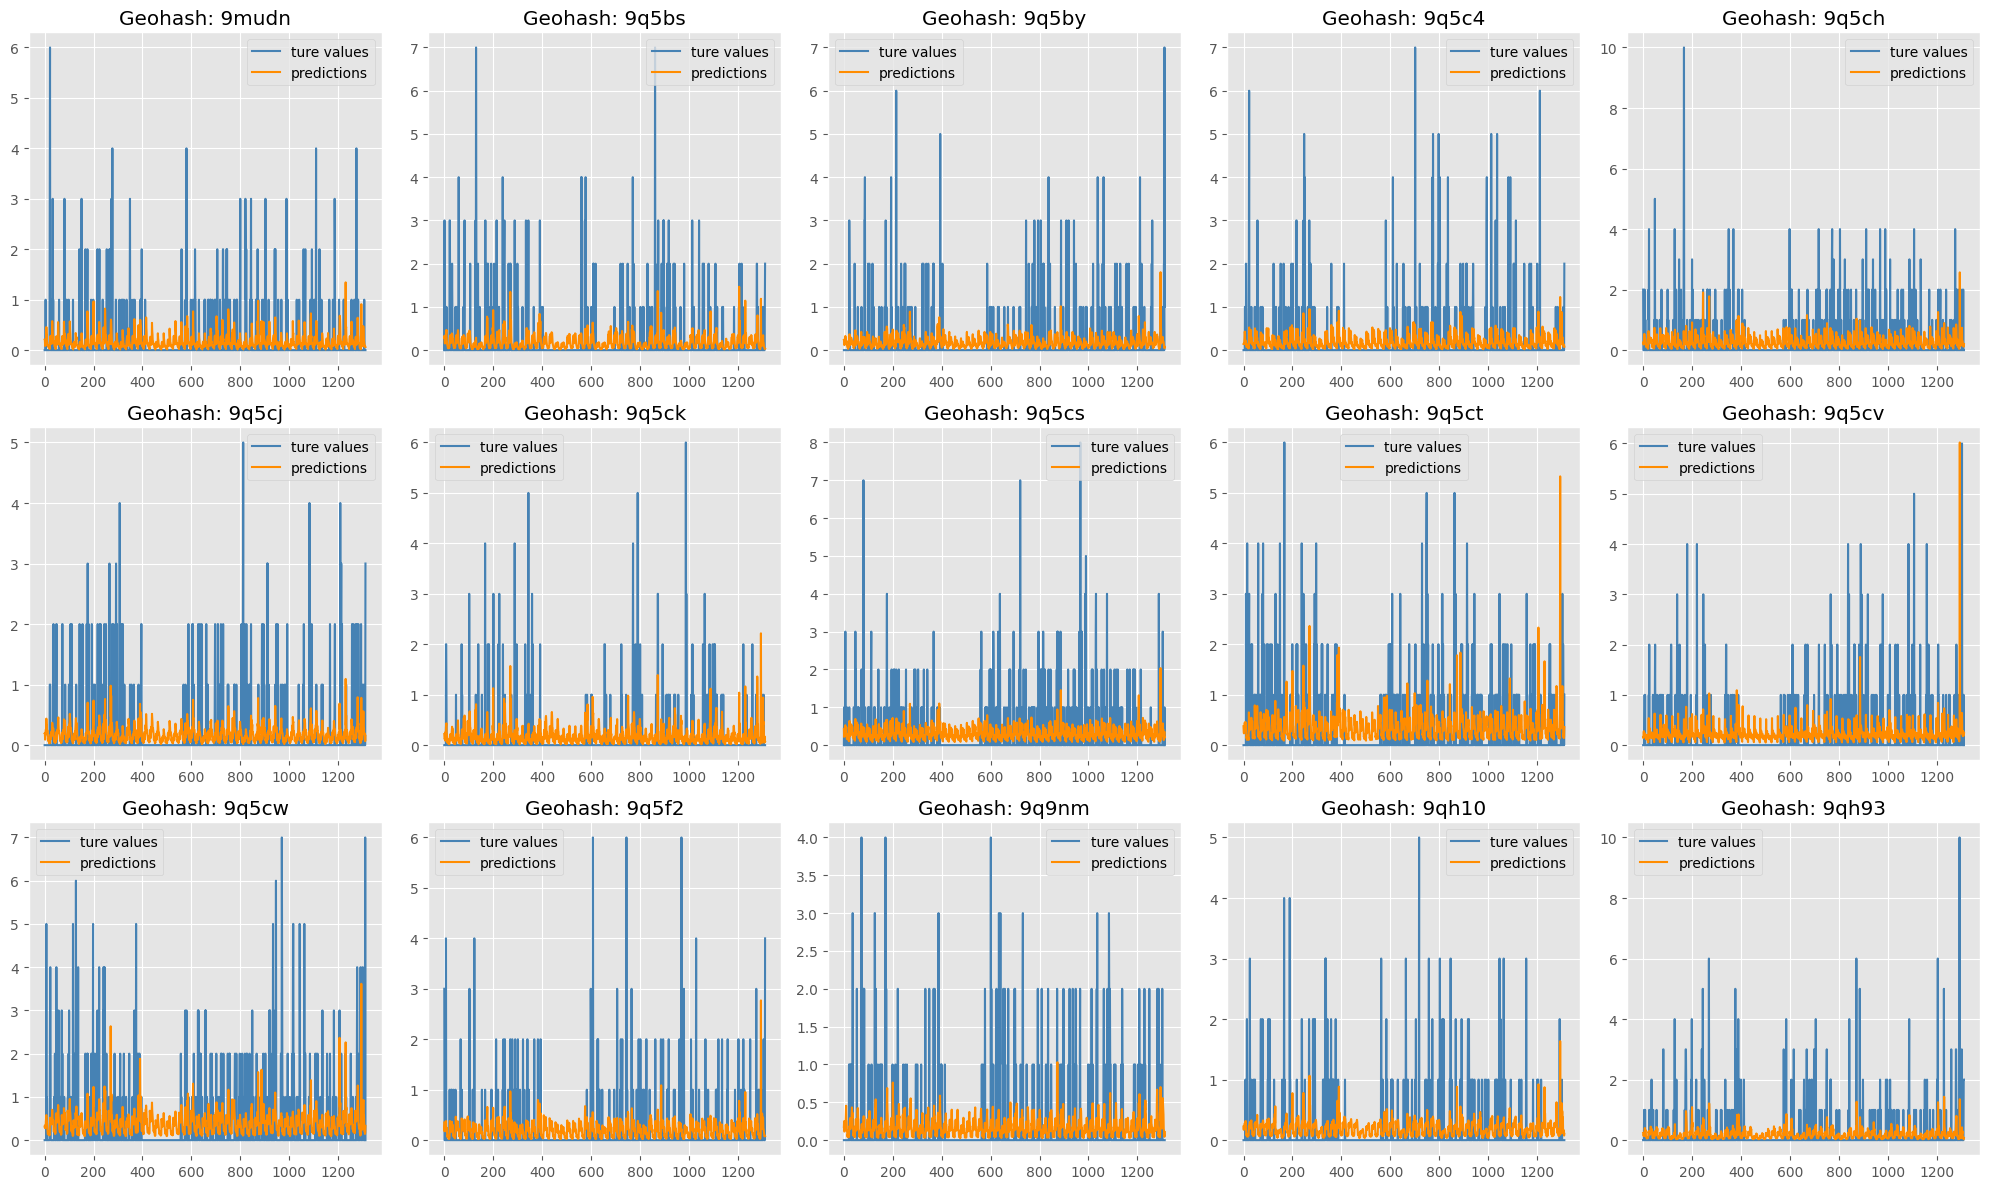

In [ ]:
# Number of rows and columns for the subplot grid
rows = 3
cols = 5

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the 2D array of axes to 1D for easy iteration
axs = axs.flatten()

# Iterate over the hashes and corresponding axes
for i, hash in enumerate(hash_df_dict.keys()):
    ax = axs[i]
    
    # Extract y_test and preds for the current hash
    y_test_hash = y_test_dict[hash]
    preds = results[hash]['preds']
    
    # Plot y_test and preds
    ax.plot(y_test_hash, label='ture values', color='steelblue')
    ax.plot(preds, label='predictions', color='darkorange')
    
    # Set the title for the subplot
    ax.set_title(f'Geohash: {hash}')
    
    # Optionally add a legend
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


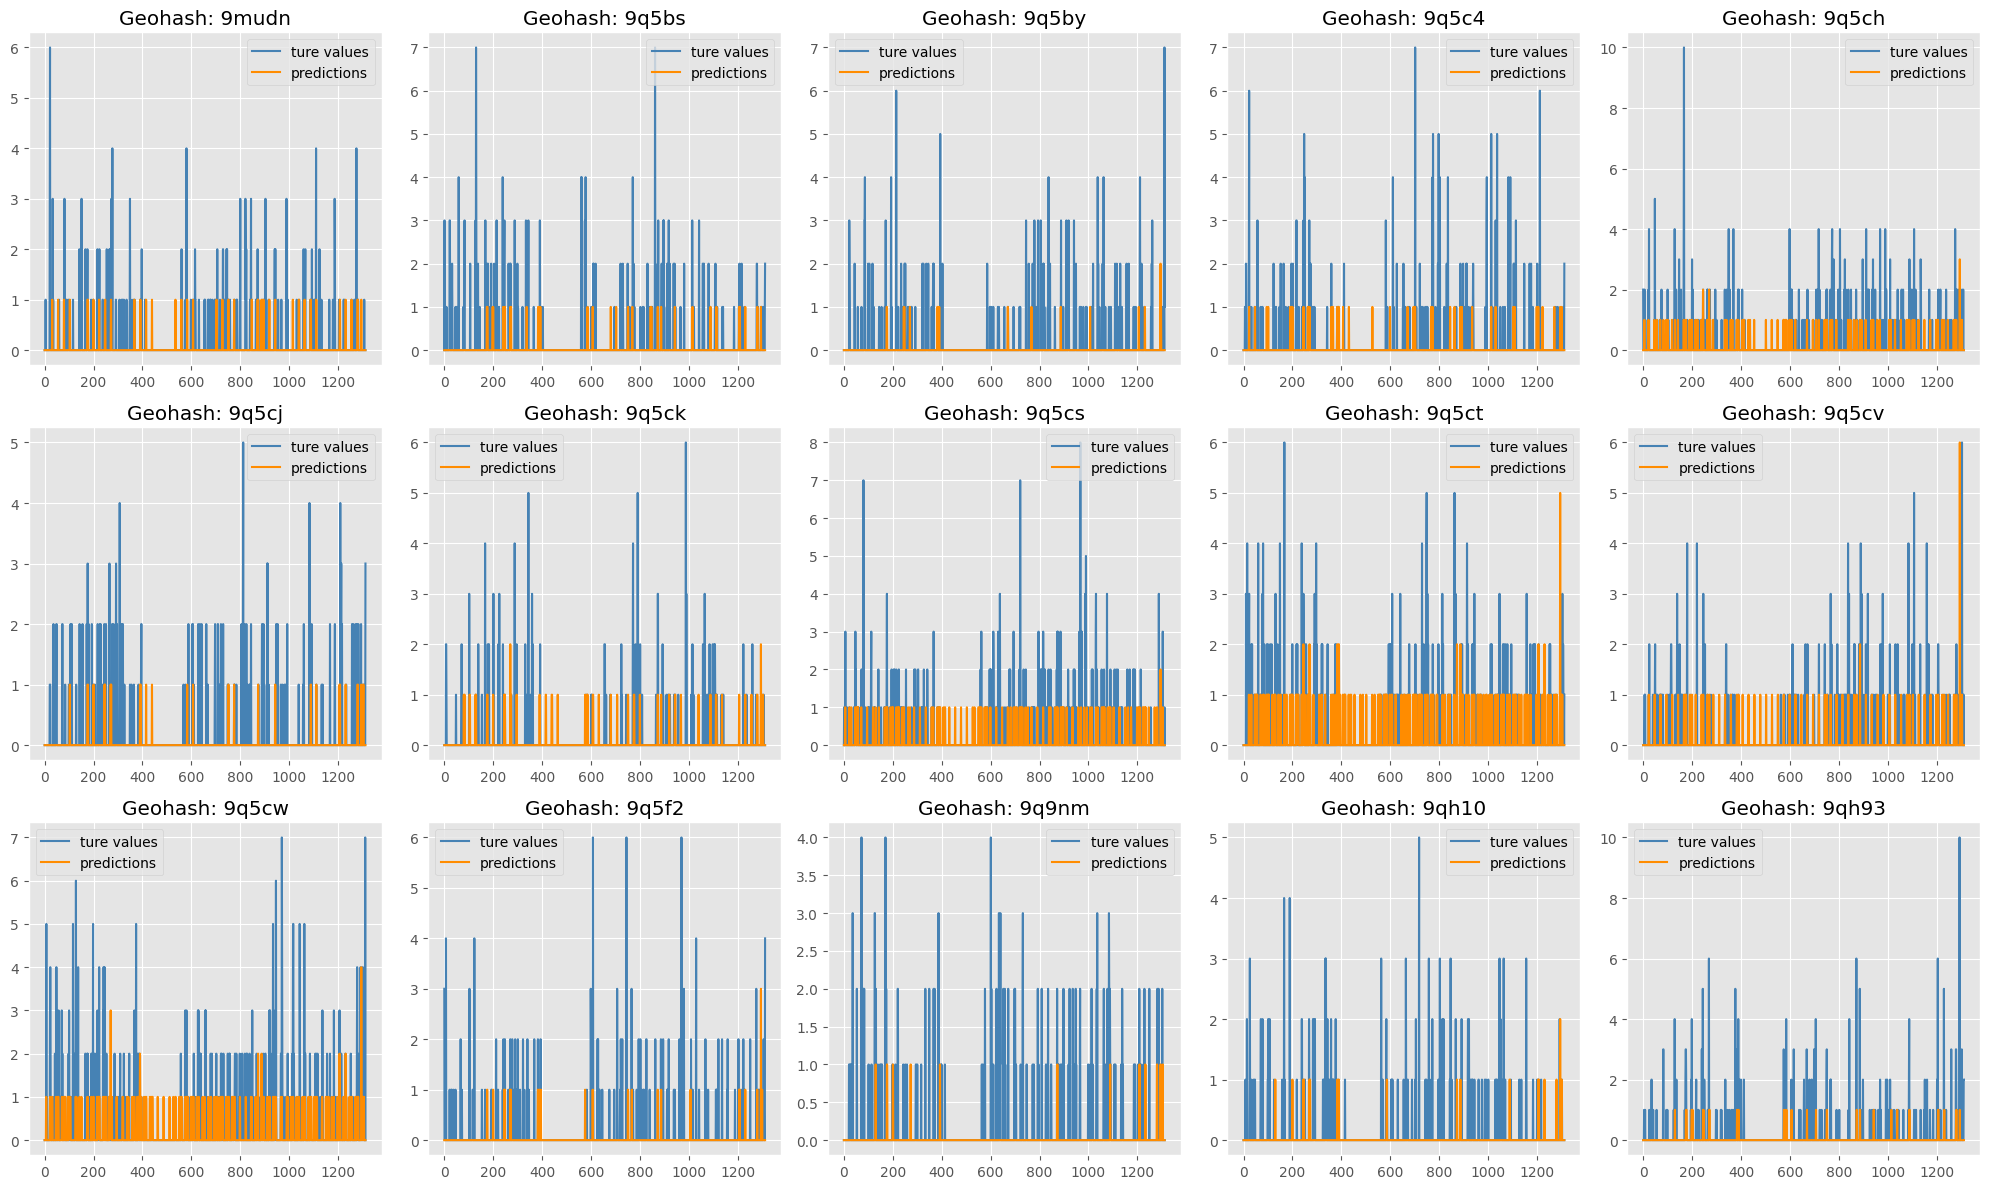

In [ ]:
# Number of rows and columns for the subplot grid
rows = 3
cols = 5

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the 2D array of axes to 1D for easy iteration
axs = axs.flatten()

# Iterate over the hashes and corresponding axes
for i, hash in enumerate(hash_df_dict.keys()):
    ax = axs[i]
    
    # Extract y_test and preds for the current hash
    y_test_hash = y_test_dict[hash]
    preds = np.round(results[hash]['preds'], decimals=0)
    
    # Plot y_test and preds
    ax.plot(y_test_hash, label='ture values', color='steelblue')
    ax.plot(preds, label='predictions', color='darkorange')
    
    # Set the title for the subplot
    ax.set_title(f'Geohash: {hash}')
    
    # Optionally add a legend
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

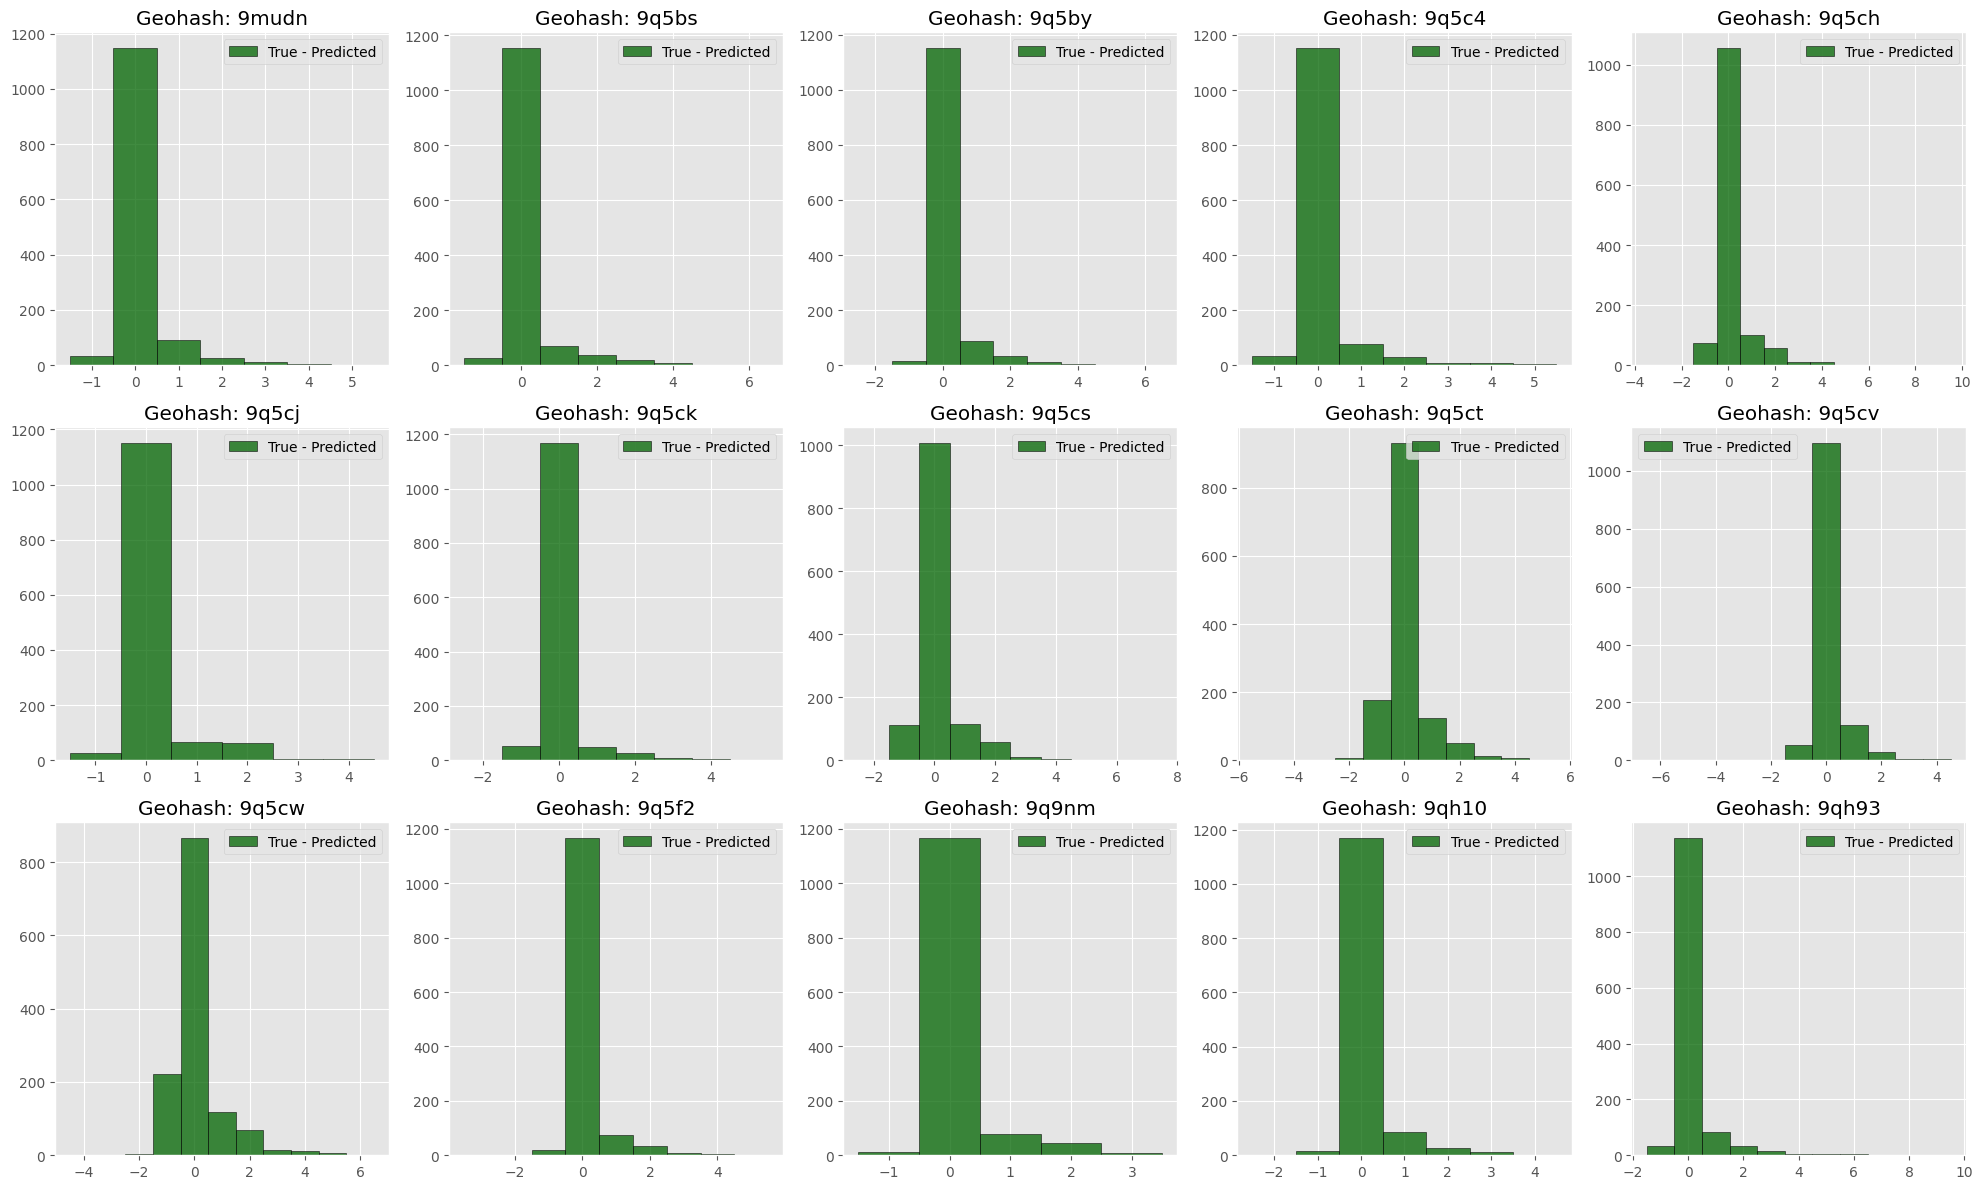

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of rows and columns for the subplot grid
rows = 3
cols = 5

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the 2D array of axes to 1D for easy iteration
axs = axs.flatten()

# Iterate over the hashes and corresponding axes
for i, hash in enumerate(hash_df_dict.keys()):
    ax = axs[i]
    
    # Extract y_test and preds for the current hash
    y_test_hash = y_test_dict[hash]
    preds = np.round(results[hash]['preds'], decimals=0)
    
    # Calculate the difference
    differences = y_test_hash - preds
    
    # Plot the histogram
    ax.hist(differences, bins=np.arange(np.min(differences), np.max(differences) + 1) - 0.5, alpha=0.75, color='darkgreen', edgecolor='black')
    
    # Set the title for the subplot
    ax.set_title(f'Geohash: {hash}')
    
    # Optionally add a legend
    ax.legend(['True - Predicted'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

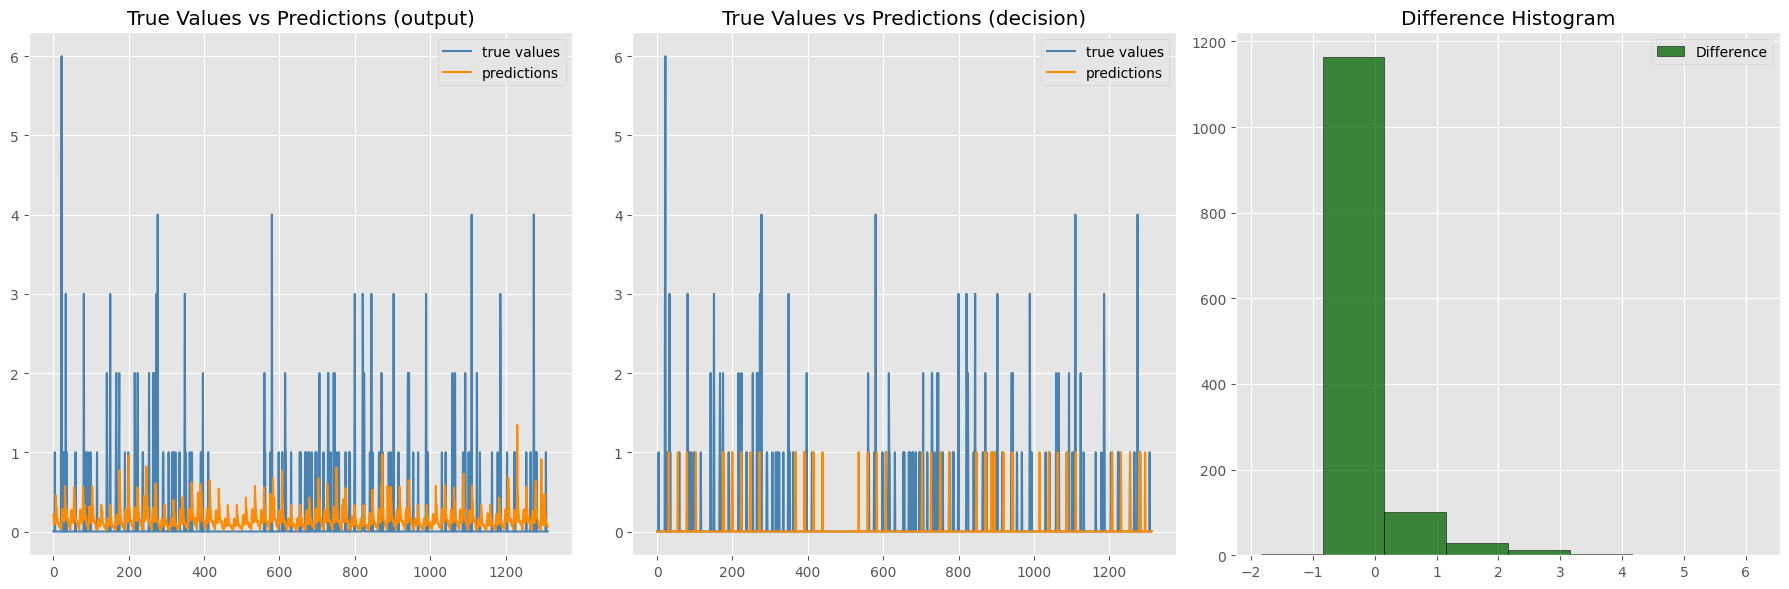

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test_dict and results are already defined

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Extract y_test and preds for the specific hash
hash = '9mudn'
y_test_hash = y_test_dict[hash]
preds = results[hash]['preds']
preds_round = np.round(results[hash]['preds'], decimals=0)

# Plot y_test and preds (First Plot)
axs[0].plot(y_test_hash, label='true values', color='steelblue')
axs[0].plot(preds, label='predictions', color='darkorange')
axs[0].set_title('True Values vs Predictions (output)')
axs[0].legend()

# Plot y_test and preds (Second Plot)
axs[1].plot(y_test_hash, label='true values', color='steelblue')
axs[1].plot(preds_round, label='predictions', color='darkorange')
axs[1].set_title('True Values vs Predictions (decision)')
axs[1].legend()

# Calculate the difference
differences = y_test_hash - preds

# Plot the histogram (Third Plot)
axs[2].hist(differences, bins=np.arange(np.min(differences), np.max(differences) + 1) - 0.5, alpha=0.75, color='darkgreen', edgecolor='black')
axs[2].set_title('Difference Histogram')
axs[2].legend(['Difference'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\balda\AppData\Local\Temp\ipykernel_25980\1122207383.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[hash]['samples']['alpha'])
C:\Users\balda\AppData\Local\Temp\ipykernel_25980\1122207383.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[hash]['samples']['alpha'])


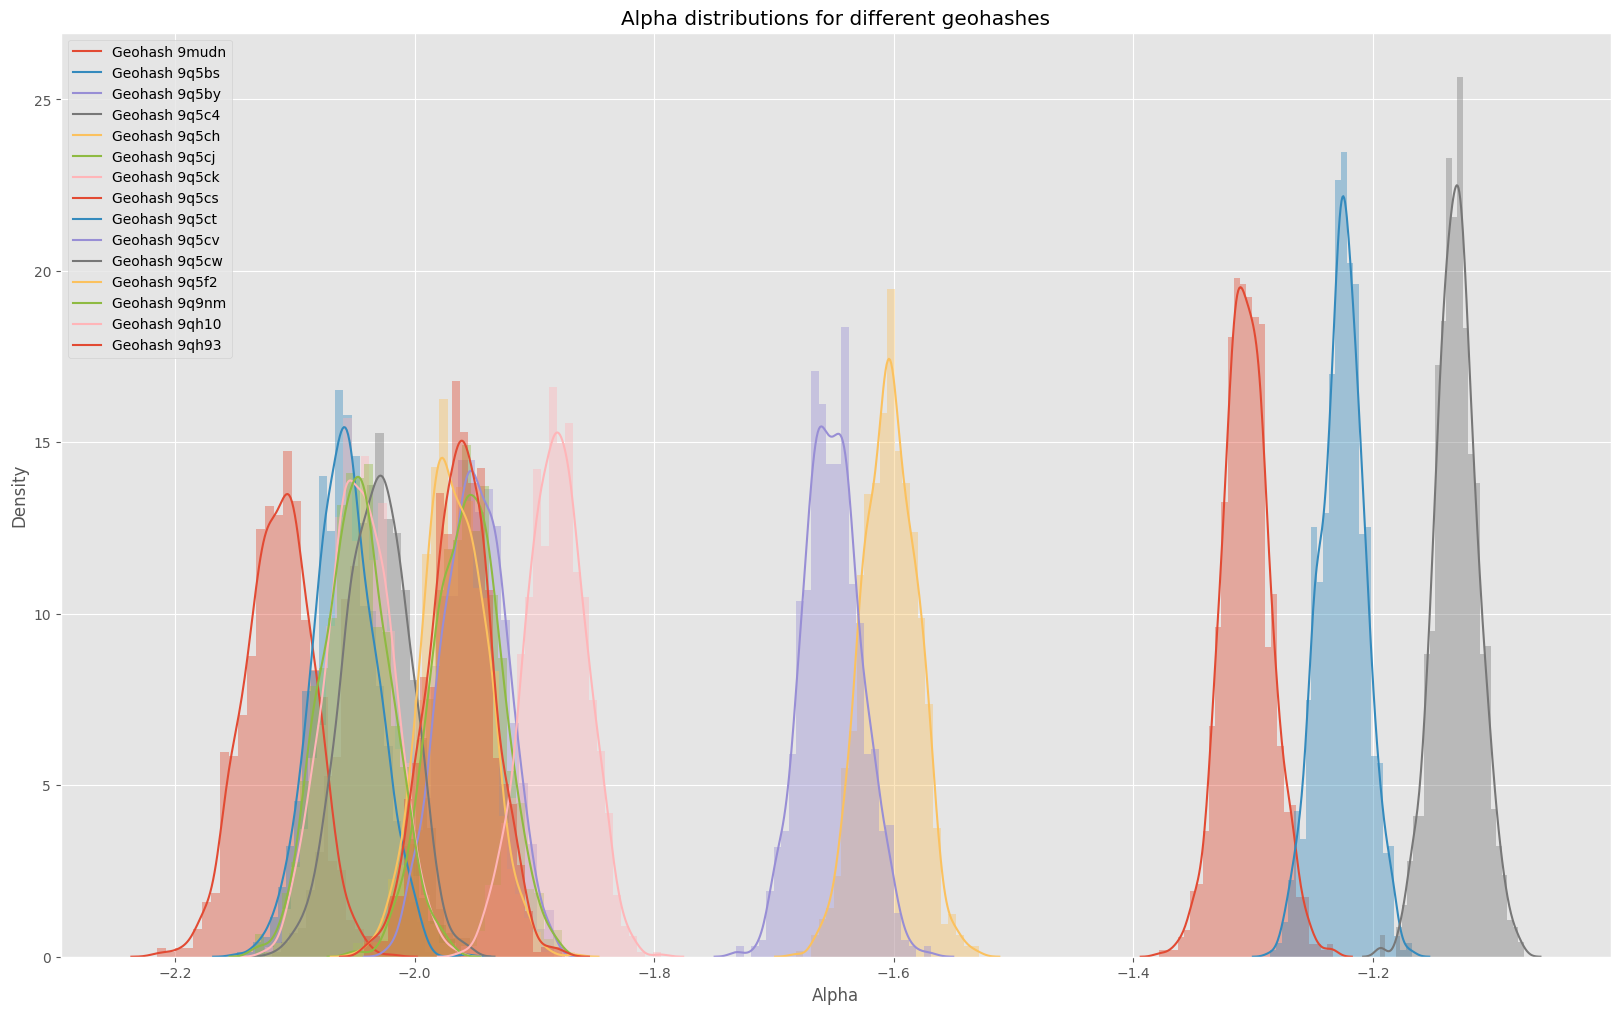

In [ ]:
# Create a figure
plt.figure(figsize=(20, 12))

# # Define a color palette
# palette = itertools.cycle(sns.color_palette("tab20", len(hash_df_dict.keys())))

# Iterate over the hashes and plot each histogram with KDE on the same figure with a different color
for hash in hash_list:
    sns.distplot(results[hash]['samples']['alpha'])

# Set the title and labels
plt.title('Alpha distributions for different geohashes')
plt.xlabel('Alpha')
plt.ylabel('Density')

# Add a legend
plt.legend([f'Geohash {hash}' for hash in hash_list])

# Show the plot
plt.show()

In [ ]:
# Create a dictionary to hold the metrics
metrics_dict = {
    'geohash': list(results.keys()),
    'corr': [],
    'mae': [],
    'rae': [],
    'rmse': [],
    'r2': []
}

# Iterate over the results and populate the metrics
for geohash, data in results.items():
    metrics_dict['corr'].append(data['errors'][0])
    metrics_dict['mae'].append(data['errors'][1])
    metrics_dict['rae'].append(data['errors'][2])
    metrics_dict['rmse'].append(data['errors'][3])
    metrics_dict['r2'].append(data['errors'][4])

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the DataFrame
metrics_df

,geohash,corr,mae,rae,rmse,r2
0,9mudn,0.126666,0.322096,0.879235,0.733529,0.009145
1,9q5bs,0.119205,0.334414,0.912859,0.735141,0.004787
2,9q5by,0.105102,0.336527,0.918627,0.734771,0.005789
3,9q5c4,0.106067,0.332889,0.908696,0.735784,0.003043
4,9q5ch,0.131539,0.394193,1.076040,0.738536,0.000000
5,9q5cj,0.139876,0.334743,0.913759,0.730509,0.017288
6,9q5ck,0.133297,0.338693,0.924541,0.735124,0.004832
7,9q5cs,0.117283,0.436879,1.192562,0.743536,0.000000
8,9q5ct,0.103531,0.468332,1.278420,0.771890,0.000000
9,9q5cv,0.031348,0.376923,1.028899,0.759475,0.000000
